# Modelos de Recomendação Baseados em Similaridade de Conteúdo

In [30]:
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.spatial.distance import cdist
from IPython.display import display
from sklearn.metrics import davies_bouldin_score, silhouette_score
import sys
sys.path.append('../auxiliarScripts')
from dataset_reader import SpotifyPlaylistDataset
from yellowbrick.cluster import KElbowVisualizer

In [2]:
# 1001 -> ambiente

### Carrega e Normaliza os Dados

In [3]:
tracks = pd.read_csv('../tracks/tracks.csv', index_col='id')
tracks

,name,duration_ms,artists,explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature
id,,,,,,,,,,,,,,,,
spotify:track:0hJkacKTAr8GZeKwcPuUk2,Yesterday's Trash,52213,"{""(24OGO7fr96L0azkG3pZZa2,\""Modern Life Is War...",t,0,0.004530,0.324,0.971,0.012800,0,0.3340,-3.168,1,0.0548,95.721,4
spotify:track:1xjFMVi8pn5VIWiqrdxAMc,promise [interlude],88888,"{""(5b0XQwyoJBFd3MwL2YxEPO,Nohidea)""}",f,0,0.833000,0.545,0.495,0.629000,11,0.3860,-13.538,1,0.1020,62.631,4
spotify:track:2ahiPTFTfIPs7UKqjKhJkc,Requiem - Alex Vidal Remix,564720,"{""(6WrPC9g41hy7LUnpxdy6u7,\""Alex Vidal\"")"",""(2...",f,0,0.033200,0.695,0.592,0.892000,0,0.5790,-9.588,1,0.0345,125.008,4
spotify:track:2z5xCMFxAo7dn6zsu6UwL9,Kaké,245356,"{""(44DhAhLWsSFvSqVXDUruVE,\""Young Paris\"")""}",t,0,0.000440,0.450,0.629,0.895000,7,0.1080,-7.059,1,0.1460,193.228,3
spotify:track:16axQgz02GFMiU2xKMT4qJ,F the Bull$h1t - Original Mix,315773,"{""(2ohlvFf9PBsDELdRstPtlP,\""Ferry Corsten\"")""}",f,0,0.000927,0.846,0.707,0.903000,6,0.0666,-5.949,0,0.1270,127.970,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:6OjPR4Y7VGDBaJMSD3QA0t,Waking Up The Dawn,294333,"{""(7beSXA7nBwZ5xJ8jUa77ZL,\""Michael English\"")""}",f,2,0.109000,0.538,0.609,0.000006,5,0.0948,-7.392,1,0.0275,87.960,4
spotify:track:1nvTse7nkCr8tO8LOAell4,Here Comes the Star,202733,"{""(48YxSlb23RAaCd4RyHcV9V,\""Herman's Hermits\"")""}",f,0,0.698000,0.339,0.325,0.000005,2,0.5550,-11.445,1,0.0252,91.286,4
spotify:track:5vKVjyFJNtfdHXzzLaWbpz,You're With Me,293546,"{""(0WTXG5dSB0wpykAqPpEmFl,UnchainD)""}",f,0,0.018600,0.482,0.443,0.000345,4,0.1100,-8.622,1,0.0276,144.962,4


#### Para pegar uma música: tracks.loc[id]
#### Para pesquisar o nome de uma música e pegar seu id: tracks.index[tracks['name'] == "nome música"]

In [4]:
# Músicas que vão simular as músicas do usuário a serem recomendadas
classical_music_i = tracks.index[tracks['name'] == 'Symphony No.5 in C minor, Op.67: 1. Allegro con brio'][0]
rap_music = tracks.index[tracks['name'] == 'Yoshi City'][0]
anime_music = tracks.index[tracks['name'] == 'GO!!!'][0]
anime_music2 = 'spotify:track:1hi0P1Y2he1p09xnUccuAN'
kaio_music = tracks.index[tracks['name'] == 'Wrist Cry'][0]
kaio_music2 = tracks.index[tracks['name'] == 'Reptilia'][0]
eletronic_music = 'spotify:track:47qYqGPgMTh3l1PRKBHEfI' #unity FatRat

#### Deixa apenas as features que serão utilizadas e separa um dataframe com nome e artistas para poderem ser retornados no final

In [5]:
# guarda o id e nome
music_ids = tracks[['name', 'artists']]

# remove colunas que não serão utilizadas
tracks.drop(['name', 'artists', 'explicit', 'time_signature', 'mode', 'key', 'duration_ms', 'popularity'], axis=1, inplace=True)
music_ids

,name,artists
id,,
spotify:track:0hJkacKTAr8GZeKwcPuUk2,Yesterday's Trash,"{""(24OGO7fr96L0azkG3pZZa2,\""Modern Life Is War..."
spotify:track:1xjFMVi8pn5VIWiqrdxAMc,promise [interlude],"{""(5b0XQwyoJBFd3MwL2YxEPO,Nohidea)""}"
spotify:track:2ahiPTFTfIPs7UKqjKhJkc,Requiem - Alex Vidal Remix,"{""(6WrPC9g41hy7LUnpxdy6u7,\""Alex Vidal\"")"",""(2..."
spotify:track:2z5xCMFxAo7dn6zsu6UwL9,Kaké,"{""(44DhAhLWsSFvSqVXDUruVE,\""Young Paris\"")""}"
spotify:track:16axQgz02GFMiU2xKMT4qJ,F the Bull$h1t - Original Mix,"{""(2ohlvFf9PBsDELdRstPtlP,\""Ferry Corsten\"")""}"
...,...,...
spotify:track:6OjPR4Y7VGDBaJMSD3QA0t,Waking Up The Dawn,"{""(7beSXA7nBwZ5xJ8jUa77ZL,\""Michael English\"")""}"
spotify:track:1nvTse7nkCr8tO8LOAell4,Here Comes the Star,"{""(48YxSlb23RAaCd4RyHcV9V,\""Herman's Hermits\"")""}"
spotify:track:5vKVjyFJNtfdHXzzLaWbpz,You're With Me,"{""(0WTXG5dSB0wpykAqPpEmFl,UnchainD)""}"


In [6]:
tracks

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,
spotify:track:0hJkacKTAr8GZeKwcPuUk2,0.004530,0.324,0.971,0.012800,0.3340,-3.168,0.0548,95.721
spotify:track:1xjFMVi8pn5VIWiqrdxAMc,0.833000,0.545,0.495,0.629000,0.3860,-13.538,0.1020,62.631
spotify:track:2ahiPTFTfIPs7UKqjKhJkc,0.033200,0.695,0.592,0.892000,0.5790,-9.588,0.0345,125.008
spotify:track:2z5xCMFxAo7dn6zsu6UwL9,0.000440,0.450,0.629,0.895000,0.1080,-7.059,0.1460,193.228
spotify:track:16axQgz02GFMiU2xKMT4qJ,0.000927,0.846,0.707,0.903000,0.0666,-5.949,0.1270,127.970
...,...,...,...,...,...,...,...,...
spotify:track:6OjPR4Y7VGDBaJMSD3QA0t,0.109000,0.538,0.609,0.000006,0.0948,-7.392,0.0275,87.960
spotify:track:1nvTse7nkCr8tO8LOAell4,0.698000,0.339,0.325,0.000005,0.5550,-11.445,0.0252,91.286
spotify:track:5vKVjyFJNtfdHXzzLaWbpz,0.018600,0.482,0.443,0.000345,0.1100,-8.622,0.0276,144.962


### Função de normalização usando fórmula do MinMaxScaler do SKLearn 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [7]:
# função que recebe um pandas Series e a escala sem copiar memória
def scaler(X, min_=None, max_=None):
    if not min_:
        min_ = X.min()
    if not max_:
        max_ = X.max()
    return X.map(lambda x: (x - min_) / (max_ - min_))

### Normalização dos dados que não estão normalizados

In [8]:
#tracks['duration_ms'] = scaler(tracks['duration_ms'])
#tracks['popularity'] = scaler(tracks['popularity'], min_=0, max_=100)
#tracks['key'] = scaler(tracks['key'])
tracks['loudness'] = scaler(tracks['loudness'], min_=-60, max_=0)
tracks['tempo'] = scaler(tracks['tempo'])

In [9]:
tracks

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,
spotify:track:0hJkacKTAr8GZeKwcPuUk2,0.004530,0.324,0.971,0.012800,0.3340,0.875375,0.0548,0.382904
spotify:track:1xjFMVi8pn5VIWiqrdxAMc,0.833000,0.545,0.495,0.629000,0.3860,0.715648,0.1020,0.250537
spotify:track:2ahiPTFTfIPs7UKqjKhJkc,0.033200,0.695,0.592,0.892000,0.5790,0.776489,0.0345,0.500058
spotify:track:2z5xCMFxAo7dn6zsu6UwL9,0.000440,0.450,0.629,0.895000,0.1080,0.815443,0.1460,0.772952
spotify:track:16axQgz02GFMiU2xKMT4qJ,0.000927,0.846,0.707,0.903000,0.0666,0.832540,0.1270,0.511907
...,...,...,...,...,...,...,...,...
spotify:track:6OjPR4Y7VGDBaJMSD3QA0t,0.109000,0.538,0.609,0.000006,0.0948,0.810314,0.0275,0.351858
spotify:track:1nvTse7nkCr8tO8LOAell4,0.698000,0.339,0.325,0.000005,0.5550,0.747886,0.0252,0.365163
spotify:track:5vKVjyFJNtfdHXzzLaWbpz,0.018600,0.482,0.443,0.000345,0.1100,0.791368,0.0276,0.579878


## Criando Modelo de Similaridade

In [10]:
class Similarity:
    def __init__(self, distance='euclidean'):
        self.distance = distance
        self.tracks = None
        
    def fit(self, tracks, id_tracks):
        self.tracks = tracks
        self.id_tracks = id_tracks
    
    def recommend(self, user_tracks, n_tracks=5):
        # cria a música média
        mean_track = np.mean(user_tracks, axis=0)
        
        # calcula distancias e pega os indices das k músicas com menores distâncias
        dists = cdist([mean_track], self.tracks, self.distance)[0]
        k_arg_dists = np.argpartition(dists, n_tracks+1)[:n_tracks+1]
        
        k_ids = self.id_tracks.iloc[k_arg_dists]
        k_info = self.tracks.iloc[k_arg_dists]
        k_dists = pd.DataFrame(dists[k_arg_dists], columns=['Distâncias'], index=self.tracks.index[k_arg_dists])
        
        # retorna um dataframe com informação do nome, artistas, distância e features ordenadas pela distância
        return pd.concat([k_dists, k_ids, k_info], axis=1).sort_values(by=['Distâncias'])
        

### Teste de Recomendador para Música Única

In [11]:
sim2 = Similarity(distance='euclidean')
sim2.fit(tracks, music_ids)
sim2.recommend([tracks.loc[classical_music_i]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:4Znak3UnsXjRYQDSK0oP6V,0.000000,"Symphony No.5 in C minor, Op.67: 1. Allegro co...","{""(2wOqMjp9TyABvtHdOSOTUS,\""Ludwig van Beethov...",0.900,0.309,0.307,0.745,0.0929,0.764198,0.0443,0.402445
spotify:track:061pN2sHhLNI3vAPIHVn2R,0.053293,Stranger On The Shore,"{""(5bdgb81IJMXag724quaNSA,\""Acker Bilk\"")"",""(4...",0.940,0.319,0.322,0.742,0.1040,0.740200,0.0359,0.390764
spotify:track:1pKwem2d9YXLd4LUParsid,0.055306,THEME FROM LOVE STORY,"{""(1sLpCr5xThZkGHLw4H0mNE,\""101 Strings Orches...",0.900,0.289,0.315,0.716,0.1050,0.728632,0.0288,0.412557
spotify:track:1mBIJRcbAec5EkveeYrPCa,0.065940,I Got Lost,"{""(267VY6GX5LyU5c9M85ECZQ,\""Dinosaur Jr.\"")""}",0.875,0.354,0.330,0.748,0.0942,0.738983,0.0264,0.388224
spotify:track:5GA90eh24Ro95k9tywfuHo,0.069033,Unless a Grain of Wheat,"{""(3PF6OyABdvKssByiQ8Imn9,\""Forbes Ministry of...",0.886,0.359,0.292,0.738,0.1310,0.756327,0.0276,0.404209
spotify:track:42B96jvtflrB3Xo7rcJnl2,0.069542,American Civil War Fantasy,"{""(6lxjjQH0jBo0mEHO5WxFnS,\""United States Coas...",0.910,0.319,0.303,0.773,0.0794,0.741124,0.0388,0.458044


In [12]:
sim3 = Similarity(distance='euclidean')
sim3.fit(tracks, music_ids)
sim3.recommend([tracks.loc[rap_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:5Tou8lYopj9qCIFBFBomZ5,0.000000,Yoshi City,"{""(67lytN32YpUxiSeWlKfHJ3,\""Yung Lean\"")""}",0.476,0.546,0.530,0.000000,0.0955,0.784637,0.211,0.512863
spotify:track:0kDEzhgtVZfYMVm7VR7f03,0.060607,Hero,"{""(0fLP4yWtS7wE0S0QbI4IYG,\""Chan Dizzy\"")""}",0.436,0.563,0.539,0.000000,0.1220,0.796189,0.232,0.492210
spotify:track:2CIzsTwVjIWMh64Nw6S3Lp,0.061630,Heartbroken Forever,"{""(5WF5qT6fSfyd3RC2p8qpEX,\""Tender Forever\"")""}",0.518,0.534,0.509,0.000000,0.1130,0.786131,0.217,0.479625
spotify:track:4vh8S4hTWAz3DHjysBo0ai,0.061667,Cocaine,"{""(4YUcg2ee9TxMNdjhAxzZBF,Ashh)"",""(44JOYPmzHzT...",0.498,0.584,0.506,0.000028,0.1110,0.772084,0.181,0.511899
spotify:track:4va49u7BqBLAmpu7WnyuQ1,0.064300,Heartbreaker,"{""(4mwXUEKaW4ftbncf9Hi58l,Tank)""}",0.496,0.510,0.500,0.000000,0.0637,0.805677,0.217,0.519827
spotify:track:00VWUa96Clte4uNEv963vn,0.070310,Évite la,"{""(1cA379ILgR07m7XQVXyP6Q,Sneazzy)"",""(5olcgTze...",0.442,0.603,0.538,0.000049,0.1010,0.786347,0.232,0.513463


In [13]:
sim4 = Similarity(distance='euclidean')
sim4.fit(tracks, music_ids)
sim4.recommend([tracks.loc[anime_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0zFRHGYU1zP6q45qbils3z,0.000000,GO!!!,"{""(3w2HqkKa6upwuXEULtGvnY,FLOW)""}",0.0508,0.604,0.978,0.000000,0.228,0.891595,0.0573,0.536584
spotify:track:5X31etfs08Q3H7WenRHWoc,0.038166,UNBALANCE,"{""(7Jo4alROJu9Smj8IZahiP1,Dios/signalP)""}",0.0471,0.590,0.956,0.004540,0.242,0.881752,0.0395,0.548101
spotify:track:5XuGyBKKFrCoz4iwvm7k7s,0.042463,I Hope,"{""(6KhH771vq2X2Aom91nNzpZ,FTISLAND)""}",0.0580,0.590,0.976,0.000000,0.197,0.892426,0.0641,0.559893
spotify:track:5z8ynRCdK17BWNLxL8rrfZ,0.043371,Take It Like a Man,"{""(72OaDtakiy6yFqkt4TsiFt,Cher)""}",0.0678,0.613,0.950,0.000000,0.243,0.889977,0.0723,0.520019
spotify:track:62pM9hM5FdqPuUKkZTmENp,0.043751,fanfare,"{""(0udR1QMfgT37SQnL1QClTU,\""Bullet Train\"")""}",0.0426,0.613,0.943,0.000000,0.208,0.883323,0.0651,0.540000
spotify:track:4618Zrqjfr2nqeXibDUIFJ,0.044536,Make me fly - The Out In Space Story Continues,"{""(40edmg1pVhEKklKU7BCo1n,\""Timur Rodriguez\"")""}",0.0263,0.620,0.967,0.000008,0.250,0.889069,0.0475,0.516095


In [14]:
sim5 = Similarity(distance='euclidean')
sim5.fit(tracks, music_ids)
sim5.recommend([tracks.loc[kaio_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:15TJBhID2NsMMp2etO0B03,0.000000,Wrist Cry,"{""(2xvtxDNInKDV4AvGmjw6d1,Bladee)""}",0.366,0.634,0.428,0.003270,0.280,0.738906,0.0284,0.439895
spotify:track:5X7yF7u1fVGS4EyekX6ewM,0.025748,"Miami, My Amy","{""(0bc7dhY6YXL35m1G0jVwuW,\""Keith Whitley\"")""}",0.354,0.646,0.441,0.000002,0.290,0.746592,0.0272,0.433999
spotify:track:1OJpQrusmejmwnvsFQqF8c,0.035643,Annie,"{""(05Pp7SeRkvE236OxUF2qmo,Yarn)""}",0.341,0.645,0.443,0.000027,0.290,0.752599,0.0276,0.440767
spotify:track:3zyUs7o9iKVhb1xuSSi0t8,0.038462,Compañero de Mi Alma,"{""(3NUe53SAgcR19GtgfSKTpW,\""Óscar Medina\"")""}",0.374,0.646,0.413,0.000000,0.265,0.711628,0.0302,0.431942
spotify:track:0Avs2CCYWfhanvCMc5qtnK,0.040308,Friends - Acoustic,"{""(6jO0ArPsbU6gg4GehuCjoF,\""Eliza and the Bear...",0.331,0.633,0.429,0.000006,0.299,0.743912,0.0293,0.440395
spotify:track:0DT4o6GdCw5Uxqb5EDIqSf,0.043744,Don't Try To Explain,"{""(6iDaoPZVgxrTkndDCisX8F,\""Keb' Mo'\"")""}",0.386,0.649,0.452,0.000469,0.278,0.762904,0.0393,0.442339


In [15]:
sim6 = Similarity(distance='euclidean')
sim6.fit(tracks, music_ids)
sim6.recommend([tracks.loc[kaio_music2]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2hmibAtdObO8F4tnhLENuQ,0.000000,Reptilia,"{""(0epOFNiUfyON9EYx7Tpr6V,\""The Strokes\"")""}",0.000597,0.488,0.650,0.714,0.1010,0.845463,0.0336,0.632077
spotify:track:79NvOn5z1gmBhZMvAdaZzv,0.039079,L'innocent,"{""(0iF2gedsSjoVHRUh5vXSdu,\""Cirque du Soleil\"")""}",0.013300,0.496,0.638,0.687,0.0973,0.827134,0.0296,0.640021
spotify:track:1Dc4H1XvXdsRqrD6WZxYKZ,0.056278,Lower Down,"{""(4zxyqU3xB0RrPX9rL9RNln,\""Lo Tom\"")""}",0.000043,0.483,0.699,0.714,0.1210,0.853781,0.0292,0.616192
spotify:track:6LVbyUVhbhhNN7uc2bqEqg,0.060271,Strip The Soul,"{""(5NXHXK6hOCotCF8lvGM1I0,\""Porcupine Tree\"")""}",0.001920,0.537,0.670,0.716,0.1150,0.830538,0.0470,0.616992
spotify:track:3JxGBrNcvunLiznL1JJzZN,0.066181,Is This Real?,"{""(0sTTw3dw3EA0c7NaZnrJd2,Wipers)""}",0.003300,0.456,0.695,0.714,0.1310,0.839302,0.0324,0.651678
spotify:track:1QlweZy3kMgha3UlkQbjMS,0.066457,Take This Lying Down,"{""(2VS0tRcCbiMkelzGoZo9XP,\""The Lucksmiths\"")""}",0.002320,0.479,0.631,0.711,0.0732,0.797268,0.0264,0.603527


In [16]:
sim7 = Similarity(distance='euclidean')
sim7.fit(tracks, music_ids)
sim7.recommend([tracks.loc[eletronic_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:47qYqGPgMTh3l1PRKBHEfI,0.000000,Unity,"{""(3OKg7YbOIatODzkRIbLJR4,TheFatRat)""}",0.004240,0.707,0.880,0.03790,0.0534,0.874713,0.0317,0.420034
spotify:track:6Gd317x1MJZ378T6xbCpGI,0.041626,Jacuzzi Jam - Original Mix,"{""(3uMZB1LatgHJCRe7DBtgiK,Syndaesia)""}",0.000565,0.728,0.873,0.03190,0.0659,0.872125,0.0569,0.439915
spotify:track:5HRnngZD7Xgko5swVsuYIk,0.043683,How I Feel,"{""(1fwbNA9Ymk7hPxcxx67paW,\""Brown and Gammon\"")""}",0.002050,0.698,0.889,0.03740,0.0418,0.856692,0.0541,0.447963
spotify:track:3MYStY0UdBrk01XUDfYON1,0.046224,Phoenix - DJ Laszlo Remix,"{""(188VINPQh5dyNfLUkevKqf,\""Olivia Holt\"")"",""(...",0.029200,0.697,0.899,0.01050,0.0407,0.881999,0.0365,0.412001
spotify:track:6DlwyiBUy2b0JQWd6CLAQa,0.046876,Love To Love You Baby - Giorgio Moroder Feat. ...,"{""(2eogQKWWoohI3BSnoG7E2U,\""Donna Summer\"")"",""...",0.019000,0.710,0.878,0.00499,0.0623,0.853303,0.0458,0.432158
spotify:track:5TYIzi4Oa1fiRpDX0mklLN,0.047079,Hunter - Made in June Remix,"{""(4sTQVOfp9vEMCemLw50sbu,Galantis)"",""(0EJYJn2...",0.005150,0.719,0.865,0.00709,0.0827,0.871987,0.0356,0.424062


### Teste de Recomendador para Playlist de Músicas

In [17]:
class ContentBasedEvaluator:
    '''
    Esse Evaluator pretende avaliar o recomendador.
    Recebe um modelo, recomenda para as tracks de treino e retorna as distâncias que esse modelo encontrou
    para os dados de teste. Então, se temos duas músicas que consideramos parecidas, podemos colocar
    uma para ser de treino e outra de teste e então ele vai retornar a distância delas. Se for pequena isso
    mostra que o modelo percebeu similaridade
    '''
    def __init__(self, fitted_model, tracks_size):
        self.tracks_size = tracks_size
        self.fitted_model = fitted_model
        
    def evaluate(self, train_tracks, test_tracks):
        recommendations = self.fitted_model.recommend(train_tracks, n_tracks=self.tracks_size-2)
        return recommendations[recommendations.index.isin(test_tracks.index)]
    

In [18]:
cbe = ContentBasedEvaluator(sim4, len(tracks))
cbe.evaluate(
    pd.DataFrame([tracks.loc[anime_music]]), 
    pd.DataFrame([tracks.loc[classical_music_i]]))

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:4Znak3UnsXjRYQDSK0oP6V,1.366044,"Symphony No.5 in C minor, Op.67: 1. Allegro co...","{""(2wOqMjp9TyABvtHdOSOTUS,\""Ludwig van Beethov...",0.9,0.309,0.307,0.745,0.0929,0.764198,0.0443,0.402445


In [19]:
dataset = SpotifyPlaylistDataset()
dataset.read_playlist_formatted(100000)

Carregando dados da slice 0-999
Carregando dados da slice 100000-100999


,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
0,0,ZAYN,spotify:track:3NdDpSvN911VPGivFlV5d0,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,I Don’t Wanna Live Forever (Fifty Shades Darke...,spotify:album:5MxXY7DbFMUiHFTPUabgJJ,245200,I Don’t Wanna Live Forever (Fifty Shades Darker)
1,1,Halsey,spotify:track:1uoL9GX45dTnmrWQ7Ii1Ft,spotify:artist:26VFTg2z8YR0cCuwLzESi2,Not Afraid Anymore,spotify:album:4HLA2Fsva7IJafJrhG5u52,226800,Not Afraid Anymore
2,2,Bryson Tiller,spotify:track:43PuMrRfbyyuz4QpZ3oAwN,spotify:artist:2EMAnMvWE2eb56ToJVfCWs,Exchange,spotify:album:6eZdwrhB97A3EYx9QppGfl,194613,T R A P S O U L
3,3,PARTYNEXTDOOR,spotify:track:1wZqJM5FGDEl3FjHDxDyQd,spotify:artist:2HPaUgqeutzr3jx5a9WyDV,Come and See Me (feat. Drake),spotify:album:2FXGUAESmG5l9YPrzWPvHI,235477,PARTYNEXTDOOR 3 (P3)
4,4,Bryson Tiller,spotify:track:3pXF1nA74528Edde4of9CC,spotify:artist:2EMAnMvWE2eb56ToJVfCWs,Don't,spotify:album:6eZdwrhB97A3EYx9QppGfl,198293,T R A P S O U L
5,5,J. Cole,spotify:track:6I6NX6tjGsxFAsIfGzY9lJ,spotify:artist:6l3HvQ5sa6mXTsMTB19rO5,Deja Vu,spotify:album:3CCnGldVQ90c26aFATC1PW,264746,4 Your Eyez Only
6,6,Joey Bada$$,spotify:track:4ntsD33Pgsgk8rUyZLLiUV,spotify:artist:2P5sC9cVZDToPxyomzF1UH,DEVASTATED,spotify:album:6swV0WUnPygRIMgEKn6Ige,207058,ALL-AMERIKKKAN BADA$$
7,7,Noah Cyrus,spotify:track:2BrzlUj1u1CtvaJDGIKpsP,spotify:artist:55fhWPvDiMpLnE4ZzNXZyW,Make Me (Cry),spotify:album:46yAYzRhSMPA44m0MzSr6g,242081,Make Me (Cry)


In [20]:
p1 = ['spotify:track:3NdDpSvN911VPGivFlV5d0',
       'spotify:track:1uoL9GX45dTnmrWQ7Ii1Ft',
       'spotify:track:43PuMrRfbyyuz4QpZ3oAwN',
       'spotify:track:1wZqJM5FGDEl3FjHDxDyQd',
       'spotify:track:3pXF1nA74528Edde4of9CC',
       'spotify:track:6I6NX6tjGsxFAsIfGzY9lJ',
       'spotify:track:4ntsD33Pgsgk8rUyZLLiUV',
       'spotify:track:2BrzlUj1u1CtvaJDGIKpsP']

In [21]:
rec_mean = Similarity() 
rec_mean.fit(tracks, music_ids)
rec_mean.recommend(tracks.loc[p1])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0zU42XXyLpOKJ2y6A6egd5,0.036028,Need Armor,"{""(5fBcVfTWenqUDOYR5SjzEQ,\""Duwap Kaine\"")""}",0.190,0.691,0.459,0.000017,0.166,0.800518,0.154,0.519807
spotify:track:5rZKAY7OpzBY3m53a6Mi68,0.051123,Good Friends,"{""(0Bm5cFUEv8FGx1wEekHj0D,\""Jeffrey James\"")""}",0.192,0.679,0.495,0.000000,0.130,0.781988,0.149,0.552041
spotify:track:5okNoSDiGJPAD8HyEWae2f,0.054426,No Se Que Tengo Que No Se,"{""(2lHzW2pMhRYX3ohx5lZY8y,\""Los Pasteles Verde...",0.191,0.700,0.493,0.000000,0.133,0.765153,0.134,0.520287
spotify:track:0biinqb0iSI0G9e8ojzczU,0.064249,Tracy's Song,"{""(3KNIG74xSTc3dj0TRy7pGX,BLEU)""}",0.195,0.697,0.476,0.001050,0.174,0.808866,0.125,0.571694
spotify:track:0ivc6vKGX6OSJN4xZ6SwZd,0.064474,We Ain't Friends,"{""(2ZI5SpSI3z4jWeaFXr0WlC,\""Mickey Shiloh\"")"",...",0.164,0.698,0.457,0.000000,0.173,0.783944,0.117,0.480297
spotify:track:0U1KkFhpO1Y28ImIhrVwe0,0.065461,Dope Love (Feat. PeeWee Longway & Verse Simmonds),"{""(13y7CgLHjMVRMDqxdx0Xdo,\""Gucci Mane\"")"",""(0...",0.135,0.653,0.480,0.002840,0.146,0.767032,0.160,0.540176


# Modelo de Recomendação Content Based com Clusterização

In [39]:
class SimilarityMeans:
    def __init__(self, distance='euclidean'):
        self.distance = distance
        self.tracks = None
        self.id_tracks = None
        
    def fit(self, tracks, id_tracks):
        self.tracks = tracks
        self.id_tracks = id_tracks
        
    def clusterfy(self, user_tracks):
        km = KMeans()
        visualizer = KElbowVisualizer(km, k=(1,len(user_tracks)+1))
        visualizer.fit(user_tracks)
        
        elbow_v = visualizer.elbow_value_
        new_km = KMeans(n_clusters=elbow_v)
        new_km.fit(user_tracks)
        
        return new_km
    
    def recommend_clusters(self, user_tracks, n_tracks=5):
        self.tracks = self.tracks.drop(index=user_tracks.index)
        self.id_tracks = self.id_tracks.drop(index=user_tracks.index)
        
        if len(user_tracks)==1:
            return [self.recommend(user_tracks[0], n_tracks)]
        
        model = self.clusterfy(user_tracks)
        clusters = model.cluster_centers_
        tracks = []
        for i in range(len(clusters)) :
            rec = self.recommend(clusters[i], n_tracks)
            tracks.append(rec)
        
        return tracks, pd.Series(model.labels_), clusters
        
    def recommend(self, user_track, n_tracks=5):
        # calcula distancias e pega os indices das k músicas com menores distâncias
        dists = cdist([user_track], self.tracks, self.distance)[0]
        k_arg_dists = np.argpartition(dists, n_tracks)[:n_tracks]
        
        k_ids = self.id_tracks.iloc[k_arg_dists]
        k_info = self.tracks.iloc[k_arg_dists]
        k_dists = pd.DataFrame(dists[k_arg_dists], columns=['Distâncias'], index=self.tracks.index[k_arg_dists])
        
        # retorna um dataframe com informação do nome, artistas, distância e features ordenadas pela distância
        return pd.concat([k_dists, k_ids, k_info], axis=1).sort_values(by=['Distâncias'])

In [40]:
rec = SimilarityMeans(distance='euclidean')
rec.fit(tracks, music_ids)

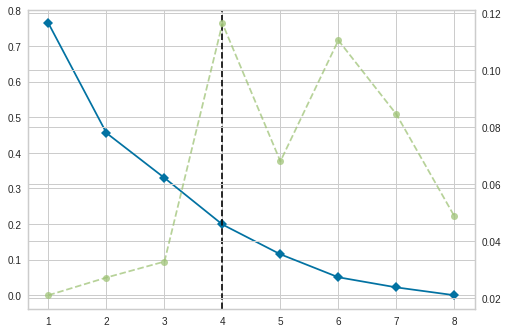

In [41]:
tracks_to_recommend = tracks.loc[p1]
recommended, labels, centroids = rec.recommend_clusters(tracks_to_recommend)

In [42]:
for i,r in enumerate(recommended):
    print(f'Músicas pertecentes ao cluster {i+1}:')
    display(music_ids.loc[tracks_to_recommend[np.array(labels==i)].index])
    print(f'Recomendação para o cluster {i+1}:')
    display(r)

Músicas pertecentes ao cluster 1:


,name,artists
id,,
spotify:track:1wZqJM5FGDEl3FjHDxDyQd,Come and See Me (feat. Drake),"{""(2HPaUgqeutzr3jx5a9WyDV,PARTYNEXTDOOR)"",""(3T..."
spotify:track:3pXF1nA74528Edde4of9CC,Don't,"{""(2EMAnMvWE2eb56ToJVfCWs,\""Bryson Tiller\"")""}"


Recomendação para o cluster 1:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1AbJj4amx7ClZ4JnNXIcp6,0.051164,How Far I'll Go,"{""(7JQVkFw40aWF95q9FpFsxA,\""Facing West\"")""}",0.118,0.740,0.366,0.0,0.0604,0.778815,0.140,0.343982
spotify:track:6hEm4Rw8MN3HOlkX0QdjBy,0.054527,Loaded,"{""(2byp8cAsQGpZLkd5zu09Jn,\""Daniel Calvin\"")""}",0.136,0.754,0.393,0.0,0.0904,0.820156,0.143,0.340022
spotify:track:46QsWO7HWBkgIq7Tjj6fN9,0.059705,Ammunition (feat. Wes Period),"{""(0Maq4Nk8ZM6keGZjTCXGIH,\""Ye Ali\"")"",""(0Pb8Z...",0.176,0.727,0.339,0.0,0.0898,0.765538,0.122,0.380860
spotify:track:7jLhzowijdegiYg2bGoPfW,0.060152,Royals (feat. Amanda Taylor),"{""(1PvW2XdqUf53cllgpYv6Ge,\""Street Corner Symp...",0.104,0.713,0.376,0.0,0.0764,0.785592,0.135,0.339550
spotify:track:2tj3R36AjWt3R4iz8vT2ov,0.060239,U,"{""(5rkVyNGXEgeUqKkB5ccK83,Ashanti)""}",0.114,0.781,0.366,0.0,0.0851,0.824423,0.102,0.360699


Músicas pertecentes ao cluster 2:


,name,artists
id,,
spotify:track:43PuMrRfbyyuz4QpZ3oAwN,Exchange,"{""(2EMAnMvWE2eb56ToJVfCWs,\""Bryson Tiller\"")""}"
spotify:track:6I6NX6tjGsxFAsIfGzY9lJ,Deja Vu,"{""(6l3HvQ5sa6mXTsMTB19rO5,\""J. Cole\"")""}"


Recomendação para o cluster 2:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:7gBz5G1JjPl7RdBhW5wXJ9,0.077866,Outro,"{""(6bvzW28MI89yFg4k5NTkR3,\""RBL Posse\"")""}",0.184,0.566,0.461,0.000000,0.150,0.728971,0.331,0.649378
spotify:track:1UwBSTLUCkuvKmNrkdUow9,0.080811,Blood Bath,"{""(2yHxc12dEUiLXNeqUadxBh,\""Tommy Lee Sparta\""...",0.206,0.593,0.495,0.000000,0.136,0.755972,0.274,0.679503
spotify:track:00pVvAwM1wlj3tVlQPmnA4,0.083208,A Mi Padre,"{""(5TTIWgDCD4KLKSypui5fAK,\""Sangre Joven\"")""}",0.164,0.585,0.448,0.000000,0.194,0.738783,0.298,0.696776
spotify:track:5CfsgrsNXu1AAh8hfX8i5z,0.084864,Who Love's You,"{""(2xpVvCGPc2HGc8edGKi7Ji,Brooklyn)""}",0.209,0.636,0.467,0.000003,0.111,0.777552,0.298,0.680395
spotify:track:0OPWexphh5T7viz73GSNvU,0.087704,Seh Weh Yuh Feel Fi Seh,"{""(2NUz5P42WqkxilbI8ocN76,\""Vybz Kartel\"")""}",0.203,0.582,0.418,0.000000,0.117,0.773208,0.366,0.667311


Músicas pertecentes ao cluster 3:


,name,artists
id,,
spotify:track:3NdDpSvN911VPGivFlV5d0,I Don’t Wanna Live Forever (Fifty Shades Darke...,"{""(5ZsFI1h6hIdQRw2ti0hz81,ZAYN)"",""(06HL4z0CvFA..."
spotify:track:1uoL9GX45dTnmrWQ7Ii1Ft,Not Afraid Anymore,"{""(26VFTg2z8YR0cCuwLzESi2,Halsey)""}"
spotify:track:4ntsD33Pgsgk8rUyZLLiUV,DEVASTATED,"{""(2P5sC9cVZDToPxyomzF1UH,\""Joey Bada$$\"")""}"


Recomendação para o cluster 3:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2v6lYsTJF3ackTmQk9h8nr,0.027220,Más,"{""(3JRFmLODLzfpDsIM6xdaLa,\""Audri Nix\"")""}",0.0497,0.700,0.590,0.000007,0.232,0.798423,0.0818,0.492362
spotify:track:0gicTUIFnZdTF6L7nL6Iwb,0.032776,Stripper Dance,"{""(3SEJQy90Vgg1aSnZ9b4AU9,\""Krizz Kaliko\"")""}",0.0353,0.696,0.579,0.000000,0.232,0.797576,0.0762,0.503866
spotify:track:74AlWa29Ryac7JkeAUjOld,0.039095,How Do You Do It,"{""(5QuBVnBPEzwYvFrgBbwpmU,\""Empress Of\"")""}",0.0620,0.726,0.609,0.000036,0.233,0.817029,0.0519,0.484101
spotify:track:6PpfF2nBRx49MxR4uiois2,0.039584,Instinct,"{""(6TxY5T8v9RjF7Ry4XQvWT5,\""Chris Travis\"")""}",0.0241,0.696,0.627,0.000000,0.252,0.818554,0.0654,0.480317
spotify:track:2cVfzlMixi8Z8TguWnAU0I,0.040925,Hold For Now,"{""(0YbpnbhAbWQrJWdEM4WGmk,Icehunt)"",""(0Znz09p5...",0.0341,0.701,0.625,0.000170,0.258,0.831061,0.0578,0.484161


Músicas pertecentes ao cluster 4:


,name,artists
id,,
spotify:track:2BrzlUj1u1CtvaJDGIKpsP,Make Me (Cry),"{""(55fhWPvDiMpLnE4ZzNXZyW,\""Noah Cyrus\"")"",""(2..."


Recomendação para o cluster 4:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2IxIwWF6pv8N6JGxMhNdud,0.041413,Two Feet On,"{""(1JPn3XQNeGEYGAxqC8apQx,\""Chris Leamy\"")""}",0.586,0.612,0.468,0.000003,0.1030,0.812532,0.0643,0.624436
spotify:track:1Aq29fxG72iNEjfSelnnqr,0.043965,Wrong Time,"{""(5A19vzcKcHWLjXwNduTRmO,\""Clay Newton\"")""}",0.608,0.589,0.459,0.000000,0.1100,0.815412,0.0532,0.599287
spotify:track:0PhAxConS0HnVz6DSvB1Zz,0.045301,Dependente,"{""(1q0fWAYirCJgGf8ysLla6y,\""Jotta A\"")""}",0.620,0.591,0.497,0.000000,0.0809,0.791260,0.0521,0.619596
spotify:track:718qNz6b7MQcIlFJvmkeKu,0.048852,Peace,"{""(3rJ3m1tM6vUgiWLjfV8sRf,\""Jimmy Cliff\"")""}",0.603,0.586,0.474,0.000000,0.0856,0.777213,0.0279,0.609172
spotify:track:5ZYg5hXr6zo92tsumjD0ln,0.049312,Without Your Skin,"{""(3JtduJLfvJEAjll8oupFy5,\""Keaton Simons\"")""}",0.600,0.575,0.492,0.000017,0.1060,0.823961,0.0475,0.632473


In [43]:
large_playlist = dataset.read_playlist_formatted(2000)['track_uri']
large_playlist

0      spotify:track:6cb0HzFQPN4BGADOmSzPCw
1      spotify:track:0HBvwy7XVhrkQljkCONgsq
2      spotify:track:5ChkMS8OtdzJeqyybCc9R5
3      spotify:track:6L89mwZXSOwYl76YXfX13s
4      spotify:track:1jNOi6m3Hn8nLEeHCp5Msr
                       ...                 
147    spotify:track:4WjH9Bzt3kx7z8kl0awxh4
148    spotify:track:50HKpCzvLPLrcotD6E71jr
149    spotify:track:6jIGWu2my6bpv4jvNVKXwW
150    spotify:track:18V7Vm71WAsWL4I0DytbnK
151    spotify:track:4LUu3bMpuxHjwPLj84rNSx
Name: track_uri, Length: 152, dtype: object

In [44]:
rec_large = SimilarityMeans(distance='euclidean')
rec_large.fit(tracks, music_ids)

Quantidade de clusters: 23
Músicas pertecentes ao cluster 1:


,name,artists
id,,
spotify:track:62LJFaYihsdVrrkgUOJC05,Kiss,"{""(5a2EaR3hamoenG9rDuVn8j,Prince)""}"
spotify:track:33OG3eJX77UAcaTzQa0xIu,U Guessed It (Remix),"{""(0nvvVQhPQGkYTJlThLbJeu,\""OG Maco\"")"",""(17lz..."
spotify:track:3KJ7btrsyVPy2VJXBElxq6,I'm Good,"{""(0A0FS04o6zMoto8OKPsDwY,YG)""}"


Recomendação para o cluster 1:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3KiaqPMlt1setiSUbmd7zl,0.061555,Cantinero Que Le Siga,"{""(6RqzIj3qOKsNemp4GZMDH9,Duende)""}",0.04510,0.913,0.360,0.000005,0.134,0.747301,0.244,0.400153
spotify:track:3RxxZd7D99LWlrcugXTh8f,0.067550,You're Wondering Now - 2002 Remaster,"{""(6xnvNmSzmeOE1bLKnYXKW3,\""The Specials\"")""}",0.03510,0.917,0.356,0.000035,0.152,0.713799,0.244,0.461520
spotify:track:1uUs2Z0S6AI6CLImiDCRSH,0.069583,I'm F***ed Up - Main Version - explicit,"{""(5Gc3IYdgY3PVcuf8FPMxDI,Dolla)""}",0.01530,0.881,0.334,0.011100,0.175,0.745083,0.316,0.399937
spotify:track:3ufwxkXv1QF3Du04RIaw90,0.069981,Margaritas,"{""(3m5V6rhUxNJv2XNsED6D9P,Authentic)""}",0.03400,0.896,0.333,0.001020,0.136,0.746438,0.225,0.480029
spotify:track:7jDDRHJ8t5P9U7Iwn98bgf,0.074096,Problem (feat. Propaganda & Canon) - Instrumental,"{""(53VbQj8DlOTZUyLNYPUmfo,\""Chad Jones\"")"",""(7...",0.00649,0.928,0.340,0.004070,0.160,0.770744,0.219,0.396165


Músicas pertecentes ao cluster 2:


,name,artists
id,,
spotify:track:4GCd7d7GE23S9Xla1mqaqo,Jailhouse,"{""(0EdvGhlC1FkGItLOWQzG4J,Sublime)""}"
spotify:track:7uPmQttafLiJyju14JREY4,Young Americans - 2016 Remaster,"{""(0oSGxfWSnnOXhD2fKuz2Gy,\""David Bowie\"")""}"
spotify:track:6C7RJEIUDqKkJRZVWdkfkH,Stronger,"{""(5K4W6rqBFWDnAN6FQUkS6x,\""Kanye West\"")""}"
spotify:track:3awlW6flEG4juGnGCduWw9,So Lonely - Remastered 2003,"{""(5NGO30tJxFlKixkPSgXcFE,\""The Police\"")""}"


Recomendação para o cluster 2:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0Yjgr8lj8PfmaR81S3i3wL,0.043693,Jehovah Guide Me,"{""(0vVeF0dtrrEB8rPE3jlRcT,Omari)""}",0.0527,0.631,0.727,0.0,0.195,0.829952,0.134,0.341022
spotify:track:26OkA5doVwzOIbLBQTR3Ex,0.044477,I Ain't Your Puppet,"{""(6OxjXk1y4QXXRUJyldFIIG,\""Kid Frost\"")""}",0.0276,0.627,0.714,0.0,0.178,0.830707,0.138,0.344462
spotify:track:5Ok3BRh1phXfdvPAw4Rv8A,0.047720,Numbers,"{""(1bq8KittwzWjTBaTzrIlan,Logic)""}",0.0341,0.638,0.700,0.0,0.199,0.789828,0.153,0.320241
spotify:track:0giTUZoU3IF4myvdCZymnZ,0.051691,99 Bottles,"{""(1AT6GZDpKMSYItiTaHud0N,\""Prolyphic & Reanim...",0.0561,0.600,0.725,0.0,0.177,0.804599,0.173,0.337422
spotify:track:1bFjZtKMLAd63AILwrGl5l,0.053987,Golden Age,"{""(3ZvruFeycdpcMPS4EfESRk,\""Late Night Episode...",0.0229,0.607,0.703,0.0,0.168,0.833742,0.129,0.320121


Músicas pertecentes ao cluster 3:


,name,artists
id,,
spotify:track:6JEntXLt4z98CcDtIH9sU7,Animals - Extended,"{""(60d24wfXkVzDSfLS6hyCjZ,\""Martin Garrix\"")""}"
spotify:track:6ns18ZPBRy4B4n06cplufL,We Own the Night (feat. Luciana) [Original Mix],"{""(2o5jDhtHVPhrJdv3cEQ99Z,Tiësto)"",""(3534yWWzm..."
spotify:track:0nz3SonnHRwEbRQreKZTbY,Turn up the Speakers - Original Mix,"{""(4D75GcNG95ebPtNvoNVXhz,Afrojack)"",""(60d24wf..."
spotify:track:5QL61roAp5tYKdsW1a9ESY,Recess (feat. Fatman Scoop and Michael Angelak...,"{""(5he5w2lnU9x7JFhnwcekXX,Skrillex)"",""(3qnMl4D..."
spotify:track:6snnRz6kK978tSyUdejEyg,Hoohah - Radio Edit,"{""(2BQWHuvxG4kMYnfghdaCIy,\""Fox Stevenson\"")"",..."


Recomendação para o cluster 3:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:44kBQx8uaiXMFdEB8yfThR,0.041413,Trivia - Radio Edit,"{""(1NtMiyzk7AhY2SGkdPkafX,Ralvero)"",""(0Aa2FUc7...",0.000552,0.617,0.893,0.771,0.436,0.850330,0.0479,0.512167
spotify:track:0o5pAWpeUzt4GGdZ72fmcD,0.046085,Not of This Earth,"{""(2KtnZQwMQJN3uyI8eHZRvm,\""Dance With the Dea...",0.000518,0.601,0.900,0.730,0.412,0.830199,0.0702,0.471909
spotify:track:6HlTOkaJBlUI98mD0SZ9c1,0.056618,The Sound (feat. Major Lazer),"{""(3SvCpwSeoWCcjfo8zjPZKB,Autoerotique)"",""(738...",0.000278,0.651,0.930,0.738,0.472,0.838332,0.0615,0.504034
spotify:track:7qpP0XUr9lEDgdW8wa6XnE,0.060000,Nubuck (atmosperic intro),"{""(3COp2OdS41wpLpMwEMaNR3,Jiro)""}",0.008120,0.603,0.901,0.748,0.387,0.840565,0.0469,0.503698
spotify:track:0ldG2YFIYSYqZSEekxwg1Q,0.060143,Bump & Grind 2014 - Special Request VIP,"{""(0D9AnJzAnYyu1kfJFQDY5d,\""Waze & Odyssey\"")""...",0.000815,0.580,0.919,0.770,0.421,0.820526,0.0478,0.500110


Músicas pertecentes ao cluster 4:


,name,artists
id,,
spotify:track:5ChkMS8OtdzJeqyybCc9R5,Billie Jean,"{""(3fMbdgg4jU18AjLCKBhRSm,\""Michael Jackson\"")""}"
spotify:track:3k0Jp5IYHtBeSNKUEOqE0i,"So Ruff, so Tuff","{""(396Kh0m4wGUvcMUULw71yi,Zapp)""}"
spotify:track:6kotXaSQaGYxE62hVpdHWu,Werewolves of London - 2007 Remaster,"{""(3mY9Ii0cL5SQxpOTAm8SHx,\""Warren Zevon\"")""}"
spotify:track:5dNfHmqgr128gMY2tc5CeJ,Ignition - Remix,"{""(2mxe0TnaNL039ysAj51xPQ,\""R. Kelly\"")""}"
spotify:track:5uuJruktM9fMdN9Va0DUMl,Play That Funky Music,"{""(4apX9tIeHb85yPyy4F6FJG,\""Wild Cherry\"")""}"
spotify:track:74MfBIVOVHzQiJqfJ1dgTo,I Wish,"{""(7guDJrEfX3qb6FEbdPA5qi,\""Stevie Wonder\"")""}"
spotify:track:0iIY7S7uiEYC9TvVaWZHV3,Left Hand Free - Lido Remix,"{""(3XHO7cRUPCLOr6jwp8vsx5,alt-J)"",""(1aSwrSGBNG..."
spotify:track:3zBWN2RILlV8RshkKvQsW8,One Touch,"{""(25fqWEebq6PoiGQIHIrdtv,Baauer)"",""(2VAnyOxzJ..."
spotify:track:4scpF6J5uMBvoh6sFB7EL1,No Type,"{""(7iZtZyCzp3LItcw1wtPI3D,\""Rae Sremmurd\"")""}"


Recomendação para o cluster 4:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3JfIBrPnHlY0zmVFCBFGVw,0.029644,Smooth Criminal,"{""(5JOpDVM6iDz94PreUvUQSn,Euphonism)"",""(4FJGM6...",0.0919,0.798,0.599,0.000072,0.0711,0.818277,0.0693,0.459920
spotify:track:72vRgf0oI9DQgyNMcB4qOB,0.030653,Golden,"{""(1CgbNAF3Stnz1Tpipu3xdO,Elujay)""}",0.0924,0.821,0.622,0.000197,0.0864,0.816336,0.0779,0.463872
spotify:track:0nICRPS4F94DXeGExv7MOJ,0.037836,Dream About You,"{""(4UqLRnUdi1XnIP2vYpDLko,Afrobeta)""}",0.0566,0.807,0.628,0.001760,0.0759,0.796343,0.0590,0.452084
spotify:track:1t1cgWmFFNN1V0KYglrU2i,0.038410,Woke Up,"{""(3fHjwMnkM9ov8CozqkYxWY,Ramriddlz)""}",0.1010,0.802,0.628,0.000000,0.0897,0.803721,0.0953,0.467992
spotify:track:6fyzLqt1N6bSHDr0zrdc5Q,0.038886,Can't Stop The Feeling! - Acoustic,"{""(5Hc9oDGvStNGmnj44m8sHg,\""Tyler Ward\"")""}",0.0960,0.800,0.598,0.000000,0.0597,0.825439,0.0772,0.451807


Músicas pertecentes ao cluster 5:


,name,artists
id,,
spotify:track:3IrkbGQCoEPAkzJ0Tkv8nm,Dirt Off Your Shoulder,"{""(3nFkdlSjzX9mRTtwJOzDYB,JAY-Z)""}"
spotify:track:1AHfovSnGPVYKaahRtA0U6,The Message,"{""(20qISvAhX20dpIbOOzGK3q,Nas)""}"
spotify:track:1Z7C8ClE8UEaH70jCCeJH2,Ten Crack Commandments - 2014 Remaster,"{""(5me0Irg2ANcsgc93uaYrpb,\""The Notorious B.I...."
spotify:track:3xHV96EQkFNorlIFQDT88v,The Light - Club Mix,"{""(7G7KvDCLdVG0Ok511Iqc9U,\""Disco Fries\"")"",""(..."
spotify:track:3FmAUR4SPWa3P1KyDf21Fu,Roxanne - Remastered 2003,"{""(5NGO30tJxFlKixkPSgXcFE,\""The Police\"")""}"
spotify:track:24x79cBVAJFukcUYl4oKwC,I'm Doin' My Thang,"{""(179BpmLkQCRIoU68Co80f5,Gramatik)""}"
spotify:track:3aIhJDHxr1kgTSnutJxPTH,Peanut Butter Jelly,"{""(4sTQVOfp9vEMCemLw50sbu,Galantis)""}"


Recomendação para o cluster 5:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:14gaMMvECN7GMoSDqEvhUy,0.051932,Know What I Know,"{""(75zCMXd3L1e5FH2GhfH1Ph,\""Lou U\"")""}",0.0413,0.645,0.781,0.000643,0.230,0.832910,0.322,0.600295
spotify:track:2xb7IAxkxze1cQIgb303Vr,0.052502,Era,"{""(6fZ3U139Fb4VfOv7g63XhB,\""Mc Kresha\"")"",""(5g...",0.0221,0.698,0.789,0.029500,0.218,0.843954,0.331,0.600055
spotify:track:60NXXzhg8ySlAsFGx4hjnj,0.056619,Round of Applause,"{""(4AN5NyOdYFKWUIKaapPXFX,Empire)""}",0.0116,0.630,0.742,0.000000,0.232,0.832340,0.330,0.561965
spotify:track:7rwge9uArkh243ZeMymhCh,0.056844,Hold Up (feat. Big Boi),"{""(7bXgB6jMjp9ATFy66eO08Z,\""Chris Brown\"")"",""(...",0.0111,0.648,0.751,0.000000,0.275,0.839980,0.338,0.559805
spotify:track:2vXY6LTYCkjH1y6Sezhtfe,0.062573,Still Blazin (feat. Ty Gutta),"{""(0xDFKPUD6C6tCyWMjXi58J,\""King Keys\"")"",""(3q...",0.0010,0.692,0.753,0.000089,0.213,0.812285,0.365,0.575622


Músicas pertecentes ao cluster 6:


,name,artists
id,,
spotify:track:1jNOi6m3Hn8nLEeHCp5Msr,Seven Nation Army,"{""(4F84IBURUo98rz4r61KF70,\""The White Stripes\..."
spotify:track:2lXzgU19U9cSZLJtawjob6,Moar Ghosts 'n' Stuff,"{""(2CIMQHirSU0MQqyYHq0eOx,deadmau5)""}"
spotify:track:5FCHT8kMQ916mqPsZjv38t,White Noise / Red Meat - Radio Edit,"{""(00sAT5YX8W3xNd1EuqyHw9,\""Dada Life\"")""}"
spotify:track:73Q6RsHfAkW8v8CK4pLF5R,Changes,"{""(6HUm6AHJE0oisACMN6NNJ5,\""Faul & Wad\"")"",""(6..."
spotify:track:5VS7aJFWhrm5U4gO7wHbVB,Okay,"{""(7Hr9bE0u9Rl5n6QahVNRnc,\""Shiba San\"")""}"
spotify:track:2eMh8ISgK9dylE51SJUixA,My Friends Never Die,"{""(21mKp7DqtSNHhCAU2ugvUw,ODESZA)""}"
spotify:track:7avUYFehb1GscgCncPdBDK,Sun Models,"{""(21mKp7DqtSNHhCAU2ugvUw,ODESZA)"",""(7kdIgG6b9..."
spotify:track:577HuVuyCyKEblC3ihTgSn,Dumb Disco Ideas,"{""(2Vhc7Y0Kc6HzMC6glKM4h6,\""Holy Ghost!\"")""}"
spotify:track:6ICXI2waLo7zwqMp6sNo1t,Teenage Crime - Axwell & Henrik B Remode,"{""(5kp9Qhzri9LrDkzrtjt5Sh,\""Adrian Lux\"")"",""(1..."


Recomendação para o cluster 6:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0MMHNS6pmSmCBtmOMrAoLD,0.039135,Stranded In NYC [Flashback] [ABGT188],"{""(7GYKZhgIx2iOaGc9vYavsh,Duderstadt)""}",0.024200,0.731,0.610,0.796,0.135,0.786378,0.0620,0.512075
spotify:track:6bqpl6Hi7fVGycbPA55CmL,0.043647,Devant,"{""(2GJ1wriDYK0enbqODh6g6P,Sferro)""}",0.000021,0.741,0.635,0.771,0.133,0.825362,0.0355,0.527999
spotify:track:6kmlxUGx08I7Wa9F91HisA,0.045664,Sympathy - Joseph Westphal Remix,"{""(24DgIjOgNLEAetejvMBq8p,Whyman)"",""(49f4DcupM...",0.016100,0.743,0.627,0.770,0.125,0.783805,0.0357,0.508066
spotify:track:1RyHk0v1pbCbmGVBS4GCZd,0.045950,Klepht,"{""(5sm0jQ1mq0dusiLtDJ2b4R,\""Eric Prydz\"")""}",0.031200,0.740,0.633,0.758,0.131,0.787579,0.0418,0.504066
spotify:track:3FGn7F8hGpJZoUNMq9sPV9,0.047500,It Dosen't Matter Anymore,"{""(6gkHVRYMMXviNI4DglaLrr,\""Route 8\"")""}",0.000824,0.754,0.624,0.811,0.129,0.817461,0.0517,0.532736


Músicas pertecentes ao cluster 7:


,name,artists
id,,
spotify:track:6cb0HzFQPN4BGADOmSzPCw,ABC,"{""(2iE18Oxc8YSumAU232n4rW,\""The Jackson 5\"")""}"
spotify:track:6BVBkKpZK09NmifUMZqj1z,Every Other Freckle,"{""(3XHO7cRUPCLOr6jwp8vsx5,alt-J)""}"
spotify:track:1hIQPCM3oWXrpnXmgTDaKG,Can't You Hear Me Knocking - 2009 Mix,"{""(22bE4uQ6baNwSHPVcDxLCe,\""The Rolling Stones..."


Recomendação para o cluster 7:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3NPSCQMIhQ6eInyiVnRSjA,0.043365,Someday Out of the Blue,"{""(6RnUwB5FnD60Cfd2SlWnyi,\""Dubble Trubble\"")""}",0.532,0.535,0.743,0.000000,0.123,0.799871,0.0623,0.639821
spotify:track:65J216Pxb4JOdiYVFIpLx7,0.051936,Feelin' Single - Seein' Double - 2003 Remaster,"{""(5s6TJEuHTr9GR894wc6VfP,\""Emmylou Harris\"")""}",0.521,0.562,0.718,0.000020,0.128,0.801858,0.0466,0.665811
spotify:track:2KY7zgm7mpwRlVApBBN5Y2,0.054991,La Culebra (The Snake),"{""(5axgr6umLyF5Olk4I73ZcP,\""La India Canela\"")""}",0.560,0.547,0.753,0.011500,0.131,0.796867,0.0707,0.651722
spotify:track:7nLLINDw3dizYaKzPoz8sx,0.055759,עוד ישמע,"{""(3VTm1513t2LL1mSKzzyQuj,\""Ishay Ribo\"")""}",0.497,0.562,0.749,0.000068,0.102,0.811777,0.0320,0.623700
spotify:track:3KeyyoAHst0q2oyEK8Su9p,0.057787,Rock Stars,"{""(7A8U1UZFpc03H6UrSaX9wh,\""AWKWARD i\"")""}",0.476,0.557,0.731,0.008690,0.126,0.823868,0.0286,0.632565


Músicas pertecentes ao cluster 8:


,name,artists
id,,
spotify:track:5piJiL6aRhvrKBa9YuEfS9,Peace Frog,"{""(22WZ7M8sxp5THdruNY3gXt,\""The Doors\"")""}"
spotify:track:0VLdJcQUsqHBBwqPp4CIKJ,Aeroplane,"{""(0L8ExT028jH3ddEcZwqJJ5,\""Red Hot Chili Pepp..."
spotify:track:2qVZpGu1v98tvUAutqyAfJ,Get Down Tonight - 2004 Remaster,"{""(3mQBpAOMWYqAZyxtyeo4Lo,\""KC & The Sunshine ..."
spotify:track:36alsPOroeWXUyTDsoeixK,Rambo - Hardwell Edit,"{""(6VD4UEUPvtsemqD3mmTqCR,Deorro)"",""(4oJsN9lEb..."
spotify:track:3FCRydJcqZtp5bshp2MzPR,Feed The Dada - 2015 Remix,"{""(00sAT5YX8W3xNd1EuqyHw9,\""Dada Life\"")""}"
spotify:track:4WjH9Bzt3kx7z8kl0awxh4,Lean On (feat. MØ & DJ Snake),"{""(738wLrAtLtCtFOLvQBXOXp,\""Major Lazer\"")"",""(..."
spotify:track:6jIGWu2my6bpv4jvNVKXwW,Kiss Kiss,"{""(2LZDXcxJWgsJfKXZv9a5eG,\""Cashmere Cat\"")""}"


Recomendação para o cluster 8:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3yvX4KaY7FEAGM7DiZxK2s,0.044809,Charmed Life,"{""(3d2pb1dHTm8b61zAGVUVvO,\""Mick Jagger\"")""}",0.0760,0.702,0.846,0.0915,0.531,0.844909,0.0423,0.471937
spotify:track:2r3o8HYufETZgXUUZilnKH,0.073073,Addicted,"{""(7H63wD8xWXAKdYVjZmE90B,Bobina)"",""(7Im3RJDHc...",0.0910,0.672,0.846,0.1040,0.485,0.831939,0.0722,0.487957
spotify:track:4PZsf5nRJ1kmDVHsRFm6Vu,0.074755,Call It What You Want - Treasure Fingers Pre-P...,"{""(7gP3bB2nilZXLfPHJhMdvc,\""Foster The People\...",0.0161,0.714,0.828,0.1120,0.552,0.846849,0.0335,0.452156
spotify:track:1jBNuPDisEUV0dLcwKPMYw,0.075213,Please,"{""(3AeALqK6rSrW2Jby7KIyyL,\""Geoffrey O'Connor\...",0.0216,0.628,0.861,0.0721,0.496,0.845817,0.0335,0.447995
spotify:track:2UgaZdItfwSipCyAXrSOVY,0.077844,Nothing But Trouble - Instagram Models; Dance ...,"{""(6VuMaDnrHyPL1p4EHjYLi7,\""Charlie Puth\"")""}",0.0110,0.682,0.806,0.0527,0.564,0.842567,0.0395,0.491962


Músicas pertecentes ao cluster 9:


,name,artists
id,,
spotify:track:4MbV8zrWudQflnbiIzp29t,Acid Raindrops,"{""(0av074qUwLn5eyzwqoq3xh,\""People Under The S..."
spotify:track:28OkLLntKaxV9Fxk79sQkD,Officer,"{""(6MxlVTY6PmY8Nyn16fvxtb,\""Slightly Stoopid\"")""}"
spotify:track:5ByAIlEEnxYdvpnezg7HTX,Juicy - 2005 Remaster,"{""(5me0Irg2ANcsgc93uaYrpb,\""The Notorious B.I...."
spotify:track:4XHQyvbrBsQaaBUW1VvmsL,My Band,"{""(5Qi4Bb7a8C0a00NZcA77L0,D12)""}"
spotify:track:3lFr31BkSc4MxBN0iKqzI9,Survival Tactics (feat. Capital Steez),"{""(2P5sC9cVZDToPxyomzF1UH,\""Joey Bada$$\"")"",""(..."
spotify:track:4pW3aTX3kAmOaPJfc9UM12,Express Yourself,"{""(2t0kaaDtGZtmpczIAMaVTQ,\""Charles Wright & T..."


Recomendação para o cluster 9:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1HTu30woJfK3G0ZpcvDdBh,0.060766,Estilo R5,"{""(0c2yelD6HE33WZYXbn8CEJ,\""Tito Torbellino\"")""}",0.503,0.834,0.811,0.000000,0.263,0.844770,0.172,0.436323
spotify:track:3T6b49X1bCto7JxDODRbuU,0.064612,La Chica Super Poderosa,"{""(3t4QqzE7i62nLJ6nsAEswx,\""Luifer Cuello\"")"",...",0.430,0.786,0.781,0.000000,0.215,0.828381,0.179,0.391752
spotify:track:6TAtpfrEbRbyx46zfCDZm6,0.065472,Dynamite,"{""(1OFOShsIbhy1l5x73yuVyB,Shenseea)""}",0.476,0.836,0.830,0.000000,0.247,0.876007,0.149,0.404145
spotify:track:11QK6euctWHTvplf7RkSDp,0.072990,Perdona Viejo,"{""(06RZGOIcioiZBRqNbq5M3M,\""Papo Rosairo\"")"",""...",0.511,0.827,0.829,0.000000,0.281,0.850608,0.153,0.396297
spotify:track:4wPrIvNX5cLwzXuXd5OB2S,0.074556,Noche De Terror,"{""(5aB4SpKYteOJ8pAleoKkg7,\""Hector & Tito\"")""}",0.475,0.803,0.839,0.000002,0.207,0.830492,0.213,0.367951


Músicas pertecentes ao cluster 10:


,name,artists
id,,
spotify:track:5RsUlxLto4NZbhJpqJbHfN,Jessie's Girl,"{""(6IFXsrXBpwbIqtOUOiAa3p,\""Rick Springfield\"")""}"
spotify:track:6xMHglHoafdDFGXS6qfwSH,Hot Blooded,"{""(6IRouO5mvvfcyxtPDKMYFN,Foreigner)""}"
spotify:track:24ATpf896KofEEDCd13myS,Take Over Control,"{""(4D75GcNG95ebPtNvoNVXhz,Afrojack)"",""(2d6W4cn..."
spotify:track:6vxHp3CDNo0afgKGp2yi1E,Me and Julio Down by the Schoolyard,"{""(2CvCyf1gEVhI0mX6aFXmVI,\""Paul Simon\"")""}"
spotify:track:7MDKvOzNgAJ3KMCtaP2UOa,"Hella Hoes (feat. A$AP Rocky, A$AP Ferg, A$AP ...","{""(7yO4IdJjCEPz7YgZMe25iS,\""A$AP Mob\"")"",""(13u..."
spotify:track:10qPhu2ekexZziM2uztYL4,We'll Be Ok,"{""(4D75GcNG95ebPtNvoNVXhz,Afrojack)"",""(7r2uG6B..."
spotify:track:76OSY26fhv9aJ0WZTezF34,Bricks (feat. Migos),"{""(7CCjtD0hCK005Bvg2WG1a7,Carnage)"",""(6oMuImdp..."
spotify:track:6dg4jncA9hbthBGFVo2djw,White Lies - EP Version,"{""(7r8xR0LmnaAM623MmRDn1V,\""Max Frost\"")""}"
spotify:track:5oDvT6FgNqIeFFffxZVnpL,Half Full Glass Of Wine,"{""(5INjqkS1o8h1imAzPqGZBb,\""Tame Impala\"")""}"


Recomendação para o cluster 10:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0UZvlXPkGtpTEHhR8f3cE7,0.031027,Por Ti,"{""(6v8MdMs2ByHLXUdWonWFPK,\""Los Rebujitos\"")""}",0.234,0.683,0.817,0.00000,0.1020,0.827426,0.118,0.504494
spotify:track:2vz0ZUj2XwqJyoYeZhVBR2,0.033741,Galaxy (feat. Cream Team & Travis Porter),"{""(6jx0BsywvpUno7rpxFjjyF,\""DJ E.Sudd\"")"",""(6z...",0.252,0.683,0.835,0.00000,0.0833,0.822960,0.155,0.523747
spotify:track:5S6qdlwD5FFJ28xYOptZG8,0.038859,Number One,"{""(2o9KhjRqlfC7j0BYvNjpYe,\""BANKK CA$H\"")"",""(4...",0.258,0.692,0.835,0.00000,0.0766,0.853072,0.130,0.528159
spotify:track:6I1OGlHkSKZpKJkV8k3NjS,0.041074,Shits Epic Pt. II,"{""(2OlZK0VIzr7wQYSrj9bOvF,SonReal)""}",0.236,0.721,0.824,0.00000,0.1140,0.837977,0.125,0.520623
spotify:track:4KMloxGKF5z7vhJ9gAPhkI,0.042486,Los Tres Mandos,"{""(2KcKzq00Oue3sks97AVmMv,\""Mayra All-Stars\"")""}",0.263,0.677,0.813,0.00001,0.0980,0.813333,0.128,0.508566


Músicas pertecentes ao cluster 11:


,name,artists
id,,
spotify:track:6tbkCukDV2wEiyg42ZJJbC,Black River Killer,"{""(72XY3HrDdFfZXNZFCT9Zh1,\""Blitzen Trapper\"")""}"
spotify:track:1PehfITh0TTRx3LkDdV4h3,Fame - 2016 Remaster,"{""(0oSGxfWSnnOXhD2fKuz2Gy,\""David Bowie\"")""}"
spotify:track:1dv3ePjze9tPq2pk8eWJdR,Gimme Shelter,"{""(22bE4uQ6baNwSHPVcDxLCe,\""The Rolling Stones..."
spotify:track:714hERk9U1W8FMYkoC83CO,You Sexy Thing,"{""(72VzFto8DYvKHocaHYNWSi,\""Hot Chocolate\"")""}"
spotify:track:5afHIkEcVhCF1Z1CTqMUXB,Ain't Nobody (Loves Me Better),"{""(4bL2B6hmLlMWnUEZnorEtG,\""Felix Jaehn\"")"",""(..."
spotify:track:00YeYHw6zhoy1y7EPTgIkj,Shine - Kygo Remix,"{""(7D5oTJSXSHf51auG0106CQ,\""Benjamin Francis L..."


Recomendação para o cluster 11:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2RiNnpmXaqxTYmSO1KGr0l,0.036953,Snowprints,"{""(74NJ9u9oWBz7B1uFyE6GJs,\""Jack Shaw\"")""}",0.528,0.704,0.637,0.000001,0.144,0.823714,0.0556,0.425618
spotify:track:4jcBQwIZZZvdGYbNAXzeOL,0.041951,El Profugo de Tijuana,"{""(5CGtBYmVPeLhI1kM2Fn9Gv,\""Los Invasores De N...",0.538,0.717,0.595,0.000000,0.139,0.791568,0.0640,0.394389
spotify:track:0ljEOpvuBaDdoy6hIU2qFg,0.043338,Land in Sicht,"{""(1uphmI1bErhHslREq9QusL,\""Roland Kaiser\"")""}",0.518,0.728,0.627,0.000013,0.137,0.787086,0.0274,0.442279
spotify:track:2bkkQbutVlVOfcjn2Nj6Qh,0.044611,Rock of Ages,"{""(59sVmFy9oSaELdp9oX8YoM,Dynamite)""}",0.539,0.717,0.633,0.000249,0.134,0.767571,0.0790,0.430438
spotify:track:0aFZUc89NJaiItvkMhimD9,0.044827,Jarabi,"{""(5xMaTGRQqjr7dj4YSADneO,\""Tom Diakité\"")""}",0.512,0.751,0.620,0.000000,0.143,0.810668,0.0387,0.432670


Músicas pertecentes ao cluster 12:


,name,artists
id,,
spotify:track:1s16lVXTAFSS4Nm3Ygd1Qu,Amazing,"{""(5K4W6rqBFWDnAN6FQUkS6x,\""Kanye West\"")"",""(4..."
spotify:track:7DdXf9x75iEVCHWfoRwRuR,Fitzpleasure,"{""(3XHO7cRUPCLOr6jwp8vsx5,alt-J)""}"
spotify:track:7vidktgNZFQylTgH1GEnMs,Cold as Ice,"{""(6IRouO5mvvfcyxtPDKMYFN,Foreigner)""}"
spotify:track:3vCHmbyOgc6pgwLUWfU4pF,Somebody To Love - Remastered 2011,"{""(1dfeR4HaWDbWqFHLkxsg1d,Queen)""}"
spotify:track:1CQqupcyMg7176PPmIVmSj,Renegade,"{""(4salDzkGmfycRqNUbyBphh,Styx)""}"
spotify:track:0qfrk2Wa53HcBusHfkgrZN,Happy Violence,"{""(00sAT5YX8W3xNd1EuqyHw9,\""Dada Life\"")""}"
spotify:track:39C5FuZ8C8M0QI8CrMsPkR,Foreplay / Long Time,"{""(29kkCKKGXheHuoO829FxWK,Boston)""}"
spotify:track:1QEEqeFIZktqIpPI4jSVSF,More Than a Feeling,"{""(29kkCKKGXheHuoO829FxWK,Boston)""}"
spotify:track:4XjuiZdzJ1TdS85OkolHOg,Hyperparadise - Flume Mixtape Version,"{""(6nxWCVXbOlEVRexSbLsTer,Flume)"",""(1BH45DVSTe..."


Recomendação para o cluster 12:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:6YCCdldPSIXyrPs24ebUky,0.035622,The Sea,"{""(300g3vtWv9sW7tpMDqfi73,\""Dirty Mittens\"")""}",0.0728,0.523,0.612,0.000098,0.0885,0.803398,0.0517,0.527807
spotify:track:4dRnFArWSg10hFF5Tud1Z2,0.038416,Fall into You,"{""(6ySxYu68zTsO5ghsThpGtS,\""Cosmic Gate\"")"",""(...",0.0692,0.486,0.632,0.000278,0.0857,0.823914,0.0849,0.511283
spotify:track:5sz8z9sk61bGaamGtLjlUa,0.038647,Firewall,"{""(6w3KIJjRhRR0yuABLt68Rz,\""Les Friction\"")""}",0.0566,0.511,0.624,0.000000,0.1120,0.790952,0.0593,0.519971
spotify:track:1tdHvHN4pimbVrGyZKkr9l,0.038815,Blame Games,"{""(2Iyxo030DdKWKmhhEaS22p,Tedy)""}",0.0590,0.517,0.615,0.000044,0.0687,0.805924,0.0484,0.519531
spotify:track:1eM1mSOrgwX4wkxJAHkBB8,0.040393,The Everlasting Muse,"{""(4I2BJf80C0skQpp1sQmA0h,\""Belle and Sebastia...",0.0797,0.487,0.626,0.000000,0.0952,0.824823,0.0601,0.529052


Músicas pertecentes ao cluster 13:


,name,artists
id,,
spotify:track:1W1GpfPujmgp2vQqcpUhtU,Won't Get Fooled Again - Remix,"{""(67ea9eGLXYMsO2eYQRui3w,\""The Who\"")""}"
spotify:track:5hWdgGVcfTeLPAiHM6EZG9,Good Vibrations,"{""(4046bnFxFJdLEtG7F2qXaV,\""Marky Mark And The..."
spotify:track:5RByQFt9Mlo8hDYJ921tCv,"Around the World / Harder, Better, Faster, Str...","{""(4tZwfgrHOc3mvqYlEYSvVi,\""Daft Punk\"")""}"
spotify:track:1OO247bWnB5j3bjuwtMcDJ,World Domination,"{""(2P5sC9cVZDToPxyomzF1UH,\""Joey Bada$$\"")""}"
spotify:track:64zjna5dIuO7s9FCDXQMmI,Heads Will Roll - A-Trak Remix,"{""(3TNt4aUIxgfy9aoaft5Jj2,\""Yeah Yeah Yeahs\"")..."
spotify:track:1twLxJP3DWzN4NDOV01sQ5,Epsilon - Original Mix,"{""(23fqKkggKUBHNkbKtXEls4,Kygo)""}"
spotify:track:4LUu3bMpuxHjwPLj84rNSx,Mirror Maru,"{""(2LZDXcxJWgsJfKXZv9a5eG,\""Cashmere Cat\"")""}"


Recomendação para o cluster 13:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:4ONH4uRSqPbZvokdNTFg49,0.048212,Rapid Empire (Am I M.I.A.?),"{""(6V8rybt4KdMUCUEkkK9SB8,\""Canon Logic\"")""}",0.158,0.672,0.803,0.395,0.0851,0.835112,0.0464,0.481557
spotify:track:2HCdJbWHTTAfVA4tVTO4Dg,0.057897,Silent Treatment - Passion Pit Remix,"{""(4LdZNE5MHGqvc0N9ivXNF3,\""The Joy Formidable...",0.126,0.691,0.823,0.327,0.1150,0.817661,0.0737,0.479989
spotify:track:06IcZJGZlC2xddt7sJsJpa,0.059210,Nosebleed - Call Super's Wire Mix,"{""(1FVo44KTXqxo3JxXADWTd9,\""Call Super\"")""}",0.114,0.694,0.832,0.358,0.1020,0.797036,0.0601,0.472033
spotify:track:5SibBUwIRfPc0OB1oojxUW,0.067395,La Mezcla - Paul Kalkbrenner Remix,"{""(1Z3YALUvy9vTgspTFWfvJS,\""Michel Cleis Feat....",0.153,0.655,0.830,0.348,0.0780,0.794403,0.0330,0.500134
spotify:track:0fkIVf18lFHDQnkQlUJoUI,0.068640,Les commencements,"{""(1yjAx9cww4f1QuAaN3dUI2,Desireless)""}",0.176,0.661,0.838,0.348,0.0902,0.815520,0.0410,0.520207


Músicas pertecentes ao cluster 14:


,name,artists
id,,
spotify:track:2CIRyBgH4ybwRRrAi45hbx,Guns Are Drawn,"{""(78xUyw6FkVZrRAtziFdtdu,\""The Roots\"")"",""(4l..."
spotify:track:69bHJ9qs5FrUJbKP8xU8uZ,Disco Inferno,"{""(3q7HBObVc0L8jNeTe5Gofh,\""50 Cent\"")""}"
spotify:track:7KwZNVEaqikRSBSpyhXK2j,Hypnotize - 2014 Remaster,"{""(5me0Irg2ANcsgc93uaYrpb,\""The Notorious B.I...."
spotify:track:20LxTsa6936zOlzTWqoPVt,The Next Episode,"{""(6DPYiyq5kWVQS4RGwxzPC7,\""Dr. Dre\"")"",""(7hJc..."
spotify:track:0l08dcPEqNEUhymVBext8h,My Name Is,"{""(7dGJo4pcD2V6oG8kP0tJRR,Eminem)""}"
spotify:track:7lQ8MOhq6IN2w8EYcFNSUk,Without Me,"{""(7dGJo4pcD2V6oG8kP0tJRR,Eminem)""}"
spotify:track:52IuMfbQa9aqRPz2oYPAI8,Express Yourself,"{""(4EnEZVjo3w1cwcQYePccay,N.W.A.)""}"
spotify:track:7xVLFuuYdAvcTfcP3IG3dS,"Work REMIX (feat. A$AP Rocky, French Montana, ...","{""(5dHt1vcEm9qb8fCyLcB3HL,\""A$AP Ferg\"")"",""(13..."
spotify:track:3j0oWeUZjTA0HDUS5j64Vm,While I Was Playin' Fair,"{""(179BpmLkQCRIoU68Co80f5,Gramatik)""}"


Recomendação para o cluster 14:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:6lLax7aQQO4KDpZBqAetkR,0.036804,Bleezies & Heem,"{""(4sv6VJ2QZlaSosz3kFlxQH,\""Mac Dre\"")""}",0.0878,0.870,0.712,0.000000,0.170,0.840149,0.240,0.384124
spotify:track:7qvWhFNMnm1qHpvzbrAt8s,0.040274,V.I.P (feat. The Hillside Stranglaz),"{""(6k7TX5dxiKZiwMWTn8ZKbl,\""Celly Cel\"")"",""(5b...",0.0663,0.861,0.687,0.000000,0.169,0.831893,0.207,0.400053
spotify:track:5sv1DKnjrJ1XNDqZh6KOBA,0.045768,Purple House,"{""(4TqmaFJYM8SvuhrunxpmT3,\""Spice 1\"")"",""(6nlt...",0.0370,0.882,0.734,0.000157,0.183,0.843461,0.234,0.390872
spotify:track:3lc3JEwcx4YY9G4qnM24Ib,0.047525,County Jail,"{""(5ppnEFVYhZ3leysA1DNAPJ,Jv)"",""(1XtYPXOEYnDjO...",0.0556,0.901,0.733,0.000000,0.202,0.850561,0.238,0.403645
spotify:track:5OhCEzFDQKig38WOcrfwiy,0.047653,My Loved One,"{""(0LyfQWJT6nXafLPZqxe9Of,\""Various Artists\"")...",0.0777,0.880,0.736,0.000000,0.184,0.850839,0.252,0.381168


Músicas pertecentes ao cluster 15:


,name,artists
id,,
spotify:track:6L89mwZXSOwYl76YXfX13s,Basket Case,"{""(7oPftvlwr6VrsViSDV7fJY,\""Green Day\"")""}"
spotify:track:2aibwv5hGXSgw7Yru8IYTO,Snow (Hey Oh),"{""(0L8ExT028jH3ddEcZwqJJ5,\""Red Hot Chili Pepp..."
spotify:track:0cuq829zRNq4AEdmDJA4aw,Two Princes,"{""(2PSiyldxmJze7xiqbz658m,\""Spin Doctors\"")""}"
spotify:track:6kooDsorCpWVMGc994XjWN,Black Betty,"{""(6FITmSxIMsk6TfulFiCIIz,\""Ram Jam\"")""}"
spotify:track:3zKST4nk4QJE77oLjUZ0Ng,Hey Brother,"{""(1vCWHaC5f2uS3yhpwWbIA6,Avicii)""}"
spotify:track:36xEjbl8DtevPJgw6i9IuY,Feels like the First Time - 2008 Remaster,"{""(6IRouO5mvvfcyxtPDKMYFN,Foreigner)""}"
spotify:track:24NwBd5vZ2CK8VOQVnqdxr,Sweet Emotion,"{""(7Ey4PD4MYsKc5I2dolUwbH,Aerosmith)""}"
spotify:track:5EWPGh7jbTNO2wakv8LjUI,Free Bird,"{""(4MVyzYMgTwdP7Z49wAZHx0,\""Lynyrd Skynyrd\"")""}"
spotify:track:2frHiHPVkiNCBMPkYF83Jr,The W.A.N.D.,"{""(16eRpMNXSQ15wuJoeqguaB,\""The Flaming Lips\"")""}"


Recomendação para o cluster 15:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:4HIOBVkYavACWdidspMjQQ,0.032765,Worth the Pain,"{""(0glc9Rxc58M5zTJP0mBCGM,\""Digital Summer\"")""}",0.0514,0.467,0.859,0.000003,0.1220,0.833187,0.0832,0.464072
spotify:track:0Oz8Sp4AHL9kaPysywCHj9,0.033639,Bathroom Gurgle,"{""(5ZBQea34QfBgEDkcGEKK2b,\""Late of the Pier\"")""}",0.0356,0.439,0.876,0.000028,0.1190,0.839749,0.0983,0.456236
spotify:track:7kO2GoPflG5iL7SR8s1F5e,0.042588,Where The Heart Is Home,"{""(1jzIEzXVJ4p1kFDmio6LEL,Xandria)""}",0.0067,0.469,0.884,0.000300,0.1230,0.846187,0.1180,0.434699
spotify:track:2aiRIYlywArrG9GjK3xUs0,0.042908,Aeroplane,"{""(0fLuxKYlYZO5fMAP1QuWl4,\""The Rye Boys\"")""}",0.0392,0.473,0.840,0.000005,0.0885,0.835651,0.0982,0.468048
spotify:track:4LASwcEKtUCW7bpohKmBPR,0.043039,I Wanna Be Free,"{""(20JZFwl6HVl6yg8a4H3ZqK,\""Panic! At The Disc...",0.0158,0.486,0.878,0.000000,0.1190,0.851332,0.1010,0.479965


Músicas pertecentes ao cluster 16:


,name,artists
id,,
spotify:track:0HBvwy7XVhrkQljkCONgsq,Point/Counterpoint,"{""(1OKOTYGoCE2buxTYMegJp7,\""Streetlight Manife..."
spotify:track:6lc6S1eIoJhi6YJn6lCnHB,Feed The Dada,"{""(00sAT5YX8W3xNd1EuqyHw9,\""Dada Life\"")""}"
spotify:track:0Tsp2actykcSvJp3S5K2tM,She's Got Me Dancing,"{""(66uOhXPcCmXFosB8DkSs4b,\""Tommy Sparks\"")""}"
spotify:track:0uppYCG86ajpV2hSR3dJJ0,Give It Away,"{""(0L8ExT028jH3ddEcZwqJJ5,\""Red Hot Chili Pepp..."
spotify:track:7gA0yghKRzS6bOwPKeg0Vw,Cocaine Blues,"{""(4zkiM9DSLNAOmoS5WtSQDt,Escort)""}"
spotify:track:4Ijr3J0lnLCGZvpXBiqCjU,Bap U,"{""(7yPPzu5UdAK7yagQqjEZQm,\""Party Favor\"")""}"
spotify:track:03IxJiB8ZOH9hEQZF5mCNY,Feel The Volume,"{""(5ttgIeUVka6FLyi00Uu5h8,Jauz)""}"
spotify:track:6H4HRR3kRteksf8SFnrSCh,Gecko (Overdrive) - Extended,"{""(5nki7yRhxgM509M5ADlN1p,\""Oliver Heldens\"")""..."
spotify:track:35x6JdLCr4VWWR5ShNoAWo,Bend Ova (feat. Tyga),"{""(7sfl4Xt5KmfyDs2T3SVSMK,\""Lil Jon\"")"",""(5LHR..."


Recomendação para o cluster 16:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3hyr0LRn14qqikLXuH7cYv,0.034131,Ark,"{""(1WlxlG9IzXsq9MkneOPkxc,\""Rob Gasser\"")"",""(4...",0.0287,0.697,0.877,0.021800,0.1010,0.848806,0.0608,0.440263
spotify:track:1uBCKUGhFrPd5Ui81GDHk0,0.035734,You Don't Love Me Anymore,"{""(4CeW2xghttvllIwy4AqNSg,Aaradhna)""}",0.0460,0.701,0.883,0.000003,0.0993,0.851778,0.0622,0.443995
spotify:track:7o0vxyRUcfFO5HnKpcG0OT,0.036243,Tudo Legal,"{""(72HVleQuWbHSX9oeBMLFHQ,Florzinho)"",""(5rtM2J...",0.0486,0.706,0.876,0.000023,0.1130,0.828736,0.0566,0.460100
spotify:track:1rD9TRO8sNPF6iDMfnbOtF,0.036317,Embers feat. Jill Harris,"{""(7lZauDnRoAC3kmaYae2opv,Dabin)"",""(0sS6vdjySC...",0.0295,0.710,0.869,0.000002,0.1120,0.844847,0.0532,0.479825
spotify:track:7simWBUCntXGKX15vDFlqK,0.037945,The Red Shoes 분홍신,"{""(7EfpdFzPZp3CB8R1SgZZmL,\""Korean Poptastic\"")""}",0.0129,0.723,0.871,0.000007,0.1060,0.860558,0.0688,0.471949


Músicas pertecentes ao cluster 17:


,name,artists
id,,
spotify:track:3Oiauiojgokw9vWQvFmEoI,Eyes on Fire - Zeds Dead Remix,"{""(1FWybrAwiSa0zKibdLfZZr,\""Blue Foundation\"")..."
spotify:track:0LN0ASTtcGIbNTnjSHG6eO,Pour Some Sugar On Me (2012),"{""(6H1RjVyNruCmrBEWRbD0VZ,\""Def Leppard\"")""}"
spotify:track:3OG0bKPHVgov24bf3UXZRh,Feel the Love (feat. John Newman) - Fred V & G...,"{""(4WN5naL3ofxrVBgFpguzKo,Rudimental)"",""(34v5M..."
spotify:track:4JLojdKkKNM3rgvP2zvUGR,Jaguar,"{""(4AA8eXtzqh5ykxtafLaPOi,\""What So Not\"")""}"
spotify:track:0QAjwIEt6FVTbfASxmNolZ,HyperParadise - Flume Remix (Ganz Flip),"{""(3fmMaLC5jjf2N4EC2kTx0u,Hermitude)"",""(6sUbCA..."


Recomendação para o cluster 17:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:71dK34HmjTLDCdjv0AFm6g,0.041805,Symphony Of Destruction - Feat. Vinnie Moore &...,"{""(6yX3wacPyKAueKwOAjKT0i,\""Michael Angelo Bat...",0.00712,0.536,0.841,0.018300,0.190,0.849591,0.0892,0.588235
spotify:track:4lv20dDjSt0icK8GDCSUkH,0.045702,Runaway Train,"{""(7aW0i5ASfG998fHzkNDniL,\""The Bros. Landreth...",0.01530,0.523,0.829,0.000352,0.174,0.840765,0.0767,0.607076
spotify:track:3EHSoatJF1TxpFsjTeJot1,0.048618,Dead Man Incorporated,"{""(4xiBg5AwhlWtuxAJO9rO6f,\""Brian Setzer\"")"",""...",0.01500,0.527,0.857,0.019600,0.210,0.852887,0.0879,0.604679
spotify:track:6kzzTqO2pHF7KMUiO3ad1d,0.049365,Running with Giants,"{""(6GfiCQDFYANz5wUkSmb3Dr,\""Thousand Foot Krut...",0.00030,0.537,0.828,0.000000,0.161,0.847173,0.0847,0.631997
spotify:track:23Z4QoxjXmnPKNprzbbkbr,0.049875,Electric Wave - Original Mix,"{""(4N4XqUMMv5KXtLvCBYEIOt,\""K Theory\"")""}",0.03000,0.525,0.828,0.000238,0.178,0.841412,0.1130,0.587895


Músicas pertecentes ao cluster 18:


,name,artists
id,,
spotify:track:0pKGbgGzZ4yLydQvcgI8HN,Pour Some Sugar on Me,"{""(6H1RjVyNruCmrBEWRbD0VZ,\""Def Leppard\"")""}"


Recomendação para o cluster 18:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0jvlIcUgiERCSwNq1bW2MM,0.049039,叫我第一名,"{""(16s0YTFcyjP4kgFwt7ktrY,Mayday)""}",0.00120,0.382,0.979,0.000010,0.982,0.839625,0.234,0.680151
spotify:track:26hZ8FyqJYmkwSGPezheyL,0.051002,Conductores Suicidas - Directo Luna Park,"{""(0F9zkPxJs5duaybGwqipyC,\""Pancho Varona\"")""}",0.00252,0.373,0.961,0.000004,0.978,0.847296,0.255,0.681119
spotify:track:4CRvbQ6GdqGB8QZXGisiYV,0.056112,Going Back to Miami,"{""(1cHFz6lrt7KAsBV8j2Ny1g,\""The Blues Brothers...",0.01400,0.407,0.933,0.001470,0.979,0.819386,0.199,0.711485
spotify:track:27U9yi22w49h4AAUUfEjXV,0.065606,Remolineando,"{""(0PmYGfb6JjgzjY25cG8DSJ,FERNEL)""}",0.01370,0.356,0.944,0.000004,0.967,0.837284,0.248,0.691552
spotify:track:1gIKku55P5bS5iMsbrHQ4K,0.068199,"If I Had $1,000,000 - Live","{""(0dEvJpkqhrcn64d3oI8v79,\""Barenaked Ladies\"")""}",0.03280,0.401,0.946,0.000000,0.982,0.838532,0.226,0.648110


Músicas pertecentes ao cluster 19:


,name,artists
id,,
spotify:track:2wvMC5EyaaYQwBfiwwY2xE,Life's Been Good,"{""(5bDxAyJiTYBat1YnFJhvEK,\""Joe Walsh\"")""}"
spotify:track:1AhDOtG9vPSOmsWgNW0BEY,Bohemian Rhapsody - Remastered 2011,"{""(1dfeR4HaWDbWqFHLkxsg1d,Queen)""}"
spotify:track:1snNAXmmPXCn0dkF9DaPWw,You & Me - Flume Remix,"{""(6nS5roXSAGhTGr34W6n7Et,Disclosure)"",""(14L5r..."


Recomendação para o cluster 19:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3vxKKwa8wEiUVQ53DtvmNg,0.033616,Lovin' You More Every Day - Single Version,"{""(0iOVhN3tnSvgDbcg25JoJb,\""Etta James\"")""}",0.280,0.514,0.418,0.000300,0.180,0.771930,0.0267,0.334437
spotify:track:6BvRrkk6zEeiP1yGK7lPYC,0.039020,Baby I'm For Real,"{""(2PtqUvopa7jQE3XAdHMiVq,\""Cui Cui\"")""}",0.298,0.516,0.436,0.000078,0.170,0.795019,0.0261,0.322385
spotify:track:2539MHg1YFPhzv0B7b3Vqo,0.045278,The Unimaginable Life,"{""(3Y3xIwWyq5wnNHPp5gPjOW,\""Kenny Loggins\"")""}",0.331,0.492,0.412,0.000000,0.201,0.777013,0.0312,0.316176
spotify:track:4KQYm1mzN4SMf8eDqWkZwb,0.049583,Debout Les Fous,"{""(3GHlCojzFpvi3RBzhLiIDe,\""Paradis Français\"")""}",0.300,0.501,0.461,0.000000,0.165,0.789150,0.0283,0.335941
spotify:track:3jEJQGprFXpeICSRtPKGDc,0.050458,I'm Losing More Than I'll Ever Have,"{""(3wury2nd8idV4GecUg5xze,\""Primal Scream\"")""}",0.282,0.525,0.450,0.013600,0.173,0.770066,0.0247,0.344638


Músicas pertecentes ao cluster 20:


,name,artists
id,,
spotify:track:5oQcOu1omDykbIPSdSQQNJ,1985,"{""(5ND0mGcL9SKSjWIjPd0xIb,\""Bowling For Soup\"")""}"
spotify:track:3EWuyYElhVOPUqB8w2uLEP,Never Say Goodbye (feat. Bright Lights) - Radi...,"{""(6BrvowZBreEkXzJQMpL174,Hardwell)"",""(03MVmfi..."
spotify:track:4bHsxqR3GMrXTxEPLuK5ue,Don't Stop Believin',"{""(0rvjqX7ttXeg3mTy8Xscbt,Journey)""}"
spotify:track:0FEPq7gON5KivhwrsWN0gI,Kick Out The Epic Motherf**ker,"{""(00sAT5YX8W3xNd1EuqyHw9,\""Dada Life\"")""}"
spotify:track:6NyMWLQ9oH8o8duJhfgfSz,Hindsight,"{""(4xnMDfgEmXZEEDdITKcGuE,Audien)""}"
spotify:track:7bFNtX22XJMy5TuEpQfa3C,New Girl,"{""(31v7ijnAMVL9V7Uzr1sFcI,\""The Suicide Machin..."
spotify:track:5EYmoAWIbrnrSMMkfHpJ2t,Runaway (U & I) - Kaskade Remix,"{""(4sTQVOfp9vEMCemLw50sbu,Galantis)"",""(6TQj5BF..."


Recomendação para o cluster 20:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2CJPuuISefPv3usIx5QR6p,0.029425,Behind the Barricade,"{""(1DNagcTxMxKfEvUFpuU0ow,SNR)"",""(7MbnTNfDyXb2...",0.024100,0.523,0.864,0.00110,0.358,0.830492,0.0606,0.480309
spotify:track:3IxRwIe6hnKGo0VQx6OPYK,0.032239,Sing My Love - Live,"{""(0Onvkz1Nbs4wHXXUwOIGk8,\""Jesus Culture\"")"",...",0.002010,0.497,0.872,0.00000,0.364,0.857955,0.0477,0.480121
spotify:track:2oxpErVKFptel2tckX3b6s,0.033138,We Won't Sleep,"{""(62elZbH5Iop8UPcChp7OrU,\""Can't Swim\"")""}",0.000112,0.514,0.868,0.00470,0.368,0.846803,0.0390,0.484017
spotify:track:0FjHdZ3lgMzv474k6zR85H,0.033234,You're So Creepy,"{""(6MM2Na1OX5kh9QjazXBeIN,\""Ghost Town\"")""}",0.007980,0.509,0.856,0.00000,0.352,0.840118,0.0638,0.480145
spotify:track:6EmbYThDwiRICnOlz2Xed3,0.033765,I'm Not Crazy,"{""(6Ya3pqpMwdtNMCS0vXBvC1,\""Cody Hoffman\"")""}",0.000127,0.520,0.880,0.00123,0.371,0.851393,0.0619,0.472053


Músicas pertecentes ao cluster 21:


,name,artists
id,,
spotify:track:2g8HN35AnVGIk7B8yMucww,Big Poppa - 2005 Remaster,"{""(5me0Irg2ANcsgc93uaYrpb,\""The Notorious B.I...."
spotify:track:4gXdMZkBN1neE9nX6yRALa,Ass Like That,"{""(7dGJo4pcD2V6oG8kP0tJRR,Eminem)""}"
spotify:track:62vpWI1CHwFy7tMIcSStl8,No Role Modelz,"{""(6l3HvQ5sa6mXTsMTB19rO5,\""J. Cole\"")""}"
spotify:track:4sFbojhVXQv7dBC9PVCcRn,Sympathy For The Devil,"{""(22bE4uQ6baNwSHPVcDxLCe,\""The Rolling Stones..."


Recomendação para o cluster 21:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1gW3cGDsPmlkquKFBo23NK,0.042447,28 Grams,"{""(1zXCFUgH6FWS0iCiCKsH55,\""Kai Straw\"")""}",0.423,0.656,0.659,0.000000,0.1200,0.796528,0.324,0.369443
spotify:track:4L8xh1L3GJ9CBkr3bYwcBM,0.045709,Millions,"{""(2kXKa3aAFngGz2P4GjG5w2,SCH)""}",0.421,0.662,0.621,0.000002,0.0976,0.806247,0.304,0.416938
spotify:track:7prGz1ROewTNNYmvrm7WFk,0.048097,The Cut,"{""(5GOOpckZbOnKc83rFU5FU8,\""The Press Project\...",0.414,0.696,0.604,0.000007,0.0912,0.799655,0.313,0.372303
spotify:track:2a6uMVPcM1yRHtYUQaRBN9,0.056089,The.chronic,"{""(2nu6ZVLgiNcRcWgDKUjplH,eery)""}",0.420,0.662,0.666,0.000000,0.1130,0.792400,0.295,0.348270
spotify:track:5kccfjsIoEJETT2CHfJfYv,0.056118,"Oost West, Thuis Best","{""(1wFoE1RwBMWoWkXcFrCgsx,Josylvio)"",""(0IxgA9w...",0.412,0.673,0.631,0.000000,0.1070,0.796574,0.368,0.376864


Músicas pertecentes ao cluster 22:


,name,artists
id,,
spotify:track:4NZg8df9BxJ6spPDnr6Z9T,Rollup - Baauer Remix,"{""(2FmzVitXZjIkFolH8HXd4j,Flosstradamus)""}"


Recomendação para o cluster 22:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1rk6HqzYDtu8lyKps3z5ws,0.170274,Hells Home - Remastered,"{""(2kS4yz85MaZlxp2VaS3BEe,\""Cabaret Voltaire\"")""}",0.2020,0.624,0.981,0.495,0.671,0.809728,0.197,0.563413
spotify:track:4HX8vVO8D6pyyKfoM5OviR,0.174943,Dred Bass,"{""(1ZJvhkmB8DGtY5SbMXD40t,\""Dead Dred\"")""}",0.2560,0.628,0.904,0.599,0.649,0.810144,0.276,0.690544
spotify:track:2yL7rXbcWKWf1tLbGlkseI,0.191469,Hippie Sex Tape,"{""(0Hh9X3QxTHPE2dlAS1g8IN,\""Rome in Silver\"")""}",0.1330,0.621,0.856,0.434,0.768,0.850084,0.322,0.558549
spotify:track:1c9dv4anUlofPLzIkQCxpA,0.208669,The Chicken Dance,"{""(3at1vTRcH8tM7ZmnGXyiZs,\""Sing n Play\"")""}",0.1040,0.589,0.831,0.439,0.741,0.803475,0.295,0.727182
spotify:track:2tvqozr6LOAtyby9oaZXZf,0.209595,Dilate,"{""(0u18Cq5stIQLUoIaULzDmA,DROELOE)""}",0.0649,0.668,0.879,0.451,0.666,0.824161,0.361,0.599763


Músicas pertecentes ao cluster 23:


,name,artists
id,,
spotify:track:58DXujtdftJjcMRhwHDwhr,How We Do - Radio Edit,"{""(6BrvowZBreEkXzJQMpL174,Hardwell)"",""(3gk0OYe..."
spotify:track:6ngavex4sZrVTif1wwRof0,Boy Oh Boy,"{""(5fMUXHkw8R8eOP2RNVYEZX,Diplo)"",""(6M7RdR9ZP5..."


Recomendação para o cluster 23:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:731oSrPrjUDfIdJ5Zsmhxr,0.034295,Reverze,"{""(04Ze9i5w3NXno5DdMNpJZC,\""Olly James\"")""}",0.002400,0.531,0.925,0.894,0.0948,0.850115,0.0575,0.544300
spotify:track:4qlzZ8NuNCpK5rYz6SyIA9,0.034892,No Saint Out Of Me - Radio Edit,"{""(1YuNQvsvOsMBm0ahbxB8qM,\""Orjan Nilsen\"")""}",0.000301,0.535,0.936,0.900,0.0833,0.820387,0.0822,0.511839
spotify:track:0cullfFBX9L8lH9KGVRugm,0.037088,The Last Ride - Radio Edit,"{""(2IK99qf3aYxFWkgCkc7kQ3,LTN)"",""(7nDb9ZWc9lWJ...",0.004730,0.545,0.920,0.873,0.0792,0.834311,0.0732,0.528067
spotify:track:496K6uKe1Twrs27p4APeeV,0.038944,54,"{""(69NjLU6rit8q9XEjL50BOj,\""Mint Royale\"")""}",0.000147,0.554,0.926,0.898,0.0848,0.827057,0.0730,0.512003
spotify:track:01PUgxOVn1zZa2Q5LcyuSl,0.041583,Platitude - Allan O'Marshall Remix,"{""(3W0GRAClTAbCLRd2hRXih1,Onova)""}",0.000007,0.522,0.945,0.880,0.0924,0.832247,0.0512,0.528099


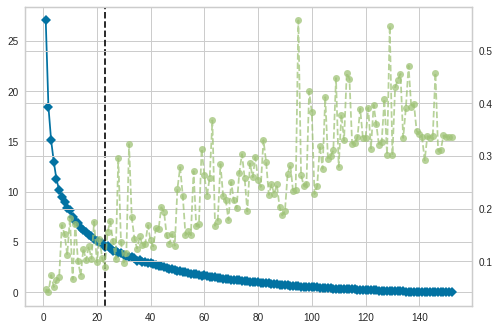

In [45]:
tracks_to_recommend = tracks.loc[large_playlist]
recommended, labels, centroids = rec_large.recommend_clusters(tracks_to_recommend)
print('Quantidade de clusters:', len(centroids))
for i,r in enumerate(recommended):
    print(f'Músicas pertecentes ao cluster {i+1}:')
    display(music_ids.loc[tracks_to_recommend[np.array(labels==i)].index])
    print(f'Recomendação para o cluster {i+1}:')
    display(r)

In [29]:
tracks.loc[['spotify:track:6NyMWLQ9oH8o8duJhfgfSz', 'spotify:track:5EYmoAWIbrnrSMMkfHpJ2t', 
           'spotify:track:0FEPq7gON5KivhwrsWN0gI', 'spotify:track:3OG0bKPHVgov24bf3UXZRh', 
           'spotify:track:0LN0ASTtcGIbNTnjSHG6eO']]

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,
spotify:track:6NyMWLQ9oH8o8duJhfgfSz,0.013200,0.537,0.935,0.000032,0.286,0.834204,0.0821,0.515031
spotify:track:5EYmoAWIbrnrSMMkfHpJ2t,0.000939,0.625,0.861,0.057900,0.271,0.870154,0.0569,0.503878
spotify:track:0FEPq7gON5KivhwrsWN0gI,0.001440,0.392,0.879,0.001800,0.322,0.834881,0.0593,0.511799
spotify:track:3OG0bKPHVgov24bf3UXZRh,0.003480,0.499,0.897,0.075800,0.203,0.867643,0.0952,0.696104
spotify:track:0LN0ASTtcGIbNTnjSHG6eO,0.009850,0.497,0.849,0.000000,0.106,0.841736,0.0612,0.679783
